# Simulator For TRPL Data

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import numpy as np
import pandas as pd
import arviz as az
import pytensor.tensor as at
from pytensor import *
from pytensor import config
config.allow_gc = False
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.gridspec as gridspec
from scipy.integrate import odeint, simpson
from scipy.optimize import root, shgo, minimize
from scipy import stats
from scipy import interpolate
import sys
import random
from scipy import signal

### Oxford color scheme
base_color = "#002147"
color_scheme = ["#44687d", "#69913b", '#cf7a30', '#be0f34']
highlight_color = "#ac48bf"

line_type_list = ['-', '-.', '--', ':']

centimeters = 1/2.54
fontsize_base = 11
figure_width = 21


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Model

In [463]:
def X_n_maker(d_factor, size, dx, D, Sf, Sb):
    x_size = at.zeros(shape=(at.shape(size),at.shape(size)))
    Xn_1 = at.extra_ops.fill_diagonal_offset(x_size, d_factor, -1)
    
    Xn_2a = at.extra_ops.fill_diagonal_offset(x_size, 1-2.*d_factor, 0)
    Xn_2a1 = at.set_subtensor(Xn_2a[0,0],1-d_factor - (dx/D)*d_factor *Sf)
    Xn_2 = at.set_subtensor(Xn_2a1[-1,-1],1-d_factor - (dx/D)*d_factor *Sb)
    
    Xn_3 = at.extra_ops.fill_diagonal_offset(x_size, d_factor, 1)
    
    return Xn_1 + Xn_2 + Xn_3


### First: Define Rate equations
def rate_equations(n_dens, nt, params):            

    k_c, k_deep, k_e, k_rad, k_aug, p0, _, _, _ = params
    
    p_dens = n_dens + nt
    #nt = p_dens-n_dens
    
    #f_t = nt/N_t
    
    #f_t = at.switch(at.le(f_t, 0), 0, f_t)
    #f_t = at.switch(at.ge(f_t, 1), 1, f_t)  

    R_rad = - k_rad*n_dens*p_dens
    R_aug = - k_aug*n_dens**3
    dnt_dt = k_c*n_dens - k_e*nt - k_deep*nt

    #dnt_dt = at.switch(at.le(dnt_dt, 0), 0, dnt_dt)
    
    R_nr =  - k_c*n_dens + k_e*nt
    
    #dnt_dt = - R_nr - k_nr*p_dens*f_t
    
    
    
    dn_dt = R_rad + R_nr + R_aug
    
    return dn_dt, dnt_dt


def Runge_Kutta_R4(n_dens, nt, dt, params):

    RuKu1_n, RuKu1_nt = rate_equations(n_dens, nt, params)
    RuKu2_n, RuKu2_nt = rate_equations(n_dens + RuKu1_n*dt/2, nt + RuKu1_nt*dt/2, params)
    RuKu3_n, RuKu3_nt = rate_equations(n_dens + RuKu2_n*dt/2, nt + RuKu2_nt*dt/2, params)
    RuKu4_n, RuKu4_nt = rate_equations(n_dens + RuKu3_n*dt, nt + RuKu3_nt*dt, params)

    Ruku_n = (RuKu1_n + 2*RuKu2_n + 2*RuKu3_n + RuKu4_n)/6
    Ruku_nt = (RuKu1_nt + 2*RuKu2_nt + 2*RuKu3_nt + RuKu4_nt)/6

    return Ruku_n, Ruku_nt



### Looping over time-domain
def total_recombination_rate(dt_current, n_dens, p_dens, ds, params):

    _, _, _, _, _, _, D, S_f, S_b = params

    
    # a. Recombination (Runge-Kutta Algorithm)
    nt = p_dens - n_dens
    Ruku_n, Ruku_nt  = Runge_Kutta_R4(n_dens, nt, dt_current, params)
    
    # b. Diffusion
    d_factor = D*dt_current/(2*ds*ds)
    A_n = X_n_maker(-d_factor, n_dens, ds, D, S_f, S_b)
    B_n = X_n_maker(d_factor, n_dens, ds, D, S_f, S_b)

    Bn_dot_n_dens = at.dot(B_n, n_dens) + Ruku_n*dt_current/2
    n_dens_new = at.dot(at.linalg.inv(A_n), Bn_dot_n_dens)

    
    # c. Physical limits
    n_dens_new = at.switch(at.le(n_dens_new, 0), 0, n_dens_new)
    p_dens_new = n_dens_new + nt + Ruku_nt*dt_current
    p_dens_new = at.switch(at.le(p_dens_new, 0), 0, p_dens_new)
    
    return n_dens_new, p_dens_new

In [464]:
"""This is the Diffusion model in PyTensor

It is mainly based on:  J. Appl. Phys. 116, 123711 (2014).
The important equations are marked.
In addition I took inspiration from:
https://www.nature.com/articles/s41598-019-41716-x#Sec16
https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-017-02670-2/MediaObjects/41467_2017_2670_MOESM1_ESM.pdf
and 
https://www.sciencedirect.com/science/article/pii/S2542435122004202#sec6.2

"""

def model_in_pytensor(time, Fluence, thickness, Absorption_coeff, p0, S_front_value, S_back_value, mu_vert, k_rad, k_deep, k_c, k_e):
    
    ## Define the spacial and temporal domains

    x = np.arange(0,thickness,30)
    z_array_np = x*1e-3
    z_array = at.as_tensor_variable(z_array_np)

    ds = at.as_tensor_variable(z_array_np[1]-z_array_np[0])
    dt = at.extra_ops.diff(time)   
    
    # Diffusion Coeffient in cm2 s-1
    limit_mobility = (thickness*1e-7)**2/(at.abs(time[1]-time[0]))/(1.380649e-23*292/1.6021766e-19)  #cm2 (Vs)-1
    Diffusion_coefficient = mu_vert*(1.380649e-23*292/1.6021766e-19)*1e8

    
    # Packing parameters
    #params = k_c, k_deep, k_e, p0, k_rad, Diffusion_coefficient
    params = k_c, k_deep, k_e, k_rad, 0, 0, Diffusion_coefficient, S_front_value, S_back_value
    
    # Initial Charge-Carrier Density
    Absorption_coeff = at.switch(at.ge(mu_vert, limit_mobility/4), 0, Absorption_coeff)
    
    generation = at.exp(-Absorption_coeff*z_array)
    generation_sum = at.sum(((generation[1:] + generation[:-1])/2), axis=0) * ds
    n_0z = Fluence/(generation_sum) * generation
    
    # re-pack parameters
    #k_c, k_nr, k_e, p0, k_rad, Diffusion_coefficient = params
    #params = k_c, k_nr, k_e, k_rad, p0, Diffusion_coefficient, S_f, S_b  

    
    result_one_sample, _ = pytensor.scan(fn=total_recombination_rate,
                                            sequences=[dt],
                                            outputs_info=[n_0z, n_0z+p0],
                                            non_sequences=[ds, params], strict=True)    

    n_init = (n_0z).dimshuffle('x',0)
    N_calc = at.concatenate([n_init, result_one_sample[0]], axis=0)
    p_init = (n_0z + p0).dimshuffle('x',0)
    P_calc = at.concatenate([p_init, result_one_sample[1]], axis=0)
 
    ## Turn radiative recombination into PL response
    # PL error parameter
    
    Rrad_calc = N_calc * P_calc
    
    PL_calc = at.sum(((Rrad_calc[:,1:] + Rrad_calc[:,:-1])/2), axis=1) * ds
    
    PL_0 = PL_calc[0]

    PL_obs = PL_calc/PL_0    
    return PL_obs, N_calc, P_calc


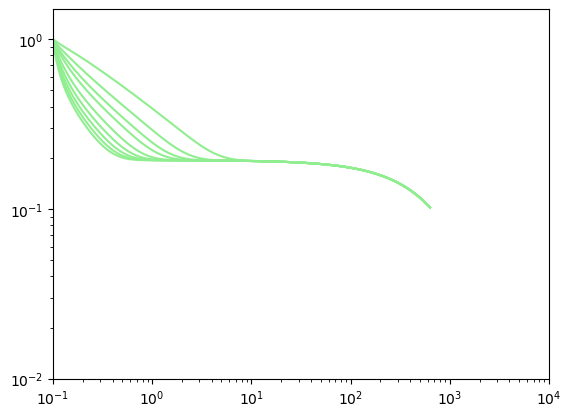

In [471]:
# Parameter Definition
Sfront = 0.1 #cm s-1
Sback = 0.1 #cm s-1
Mobility = 100 #cm2 V-1s-1


Fluence = 4.8e11   #cm-2

alpha = 3e5  #cm-1
Thickness = 600   #nm

k_rad = 1e-12   #cm3 s-1
p0 = 0#   #cm-3


k_deep = 1e6   #s-1
k_c = 0
k_e = 0

time = np.logspace(-1,2.8,200) #ns

df_save = pd.DataFrame()
df_save[f'Time'] = time

PL, n_dens, p_dens = model_in_pytensor(time*1e-9, Fluence*1e-8, Thickness, alpha*1e-4, p0*1e-12, Sfront*1e4, Sback*1e4, Mobility, k_rad*1e12, k_deep, k_c, k_e)



for test in [5, 10, 15, 20, 30, 40, 50, 60, 70]:
    #kc_p = kc_n
    #k_c = test
    Mobility = test

    PL, n_dens, p_dens = model_in_pytensor(time*1e-9, Fluence*1e-8, Thickness, alpha*1e-4, p0*1e-12, Sfront*1e4, Sback*1e4, Mobility, k_rad*1e12, k_deep, k_c, k_e)

    PL_calc = PL.eval()

#    print(np.shape(PL_calc))
#
    #df_save[f'k_c_{test}'] =  PL_calc
    plt.plot(time, PL_calc, c='lightgreen')



#data_folder_simulations = r'C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\Simulated_TRPL'
#sample_name = r'k_c'
#df_save.to_csv(f'{data_folder_simulations}/{sample_name}.dat', sep='\t', index= True, mode='w')


plt.ylim(1e-2,1.5)
plt.xlim(0.1,10000)
plt.xscale('log')
plt.yscale('log')
plt.show()



In [436]:
n = n_dens.eval() * 1e12
p = p_dens.eval() * 1e12
nt = p - n

In [450]:
dnt_dt =  k_c*n - k_e*nt
#dnt_dt[dnt_dt <= 0] = 0
R_nr = -dnt_dt - k_deep*n
k_tot = -R_nr/(n)
#k_tot[k_tot <= 0] = 0

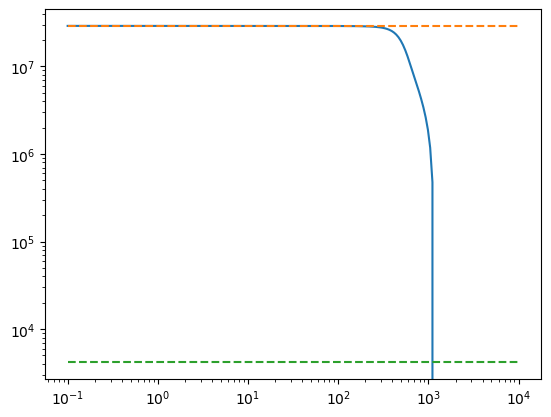

In [451]:

k_tot_av = np.max(k_tot, axis=1)
k_eff = k_deep*k_deep/(k_deep+k_c) + k_c*k_deep/(k_c+k_deep)*k_e/(k_e+k_deep)


plt.loglog(time, k_tot_av)
plt.plot(time, (k_deep +k_c + k_e)*np.ones(len(time)), linestyle='--')
plt.plot(time, k_eff*np.ones(len(time)), linestyle='--')

#plt.plot(time, np.mean(n, axis=1))
#plt.plot(time, np.mean(p, axis=1))
#plt.plot(time, np.mean(nt, axis=1))
#plt.semilogy(time, np.mean(n*p, axis=1))


In [ ]:
'''
for test in [1, 10, 100, 1000]:
    #kc_p = kc_n
    Sfront = test
    kc_p = kc_n*(2*trap_depth)**5/((2*trap_depth)**5 + (2-2*trap_depth)**5)
    
    PL, n_dens, p_dens = model_in_pytensor(time*1e-9, Fluence*1e-8, Thickness, alpha*1e-4, p0*1e-12, pn_eq*1e-12, Sfront*1e4, Sback*1e4, Mobility, k_rad*1e12, k_deep, k_c, k_e)

    PL_calc = PL.eval()

#    print(np.shape(PL_calc))
#
    df_save[f'Sfront_{test}'] =  PL_calc
    plt.semilogy(time, PL_calc, c='lightgreen')



data_folder_simulations = r'C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\Simulated_TRPL'
sample_name = r'Sfront'
df_save.to_csv(f'{data_folder_simulations}/{sample_name}.dat', sep='\t', index= True, mode='w')

plt.show()
#n_dens = n_dens.eval()
#p_dens = p_dens.eval()

#PL_simulated = PL_simulated.eval()
#n_diff_only = n_diff_only.eval()
#n_diff_recomb = n_diff_recomb.eval()
#z_coord = z_coord.eval()
#k_nr_bulk = k_nr_bulk.eval()
'''

0.5


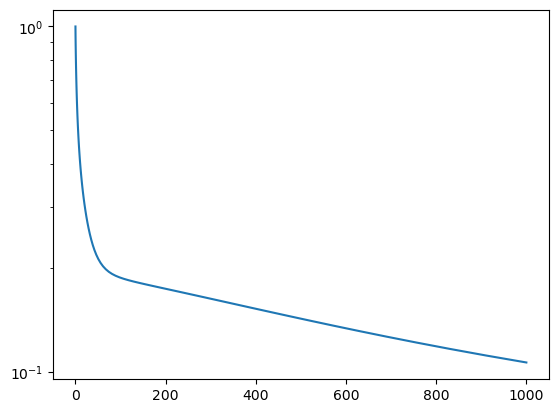

In [94]:
#plt.semilogy(np.arange(0,600,6), PLobs.T)
plt.semilogy(time, PLobs)

plt.show()

In [98]:
z_coord = np.arange(0,600,5)*1e-7
df_n_dens_time = pd.DataFrame()
df_n_dens_time['z_array(nm)'] = z_coord*1e7

k_nr = kc_p*p_dens/

i = 0
while i < len(time):

    k_nr = kc_p*p_dens/

    plt.semilogy(z_coord*1e7, n_diff_recomb[0,:,i], label=str(time[i]))
    df_n_dens_time[f'time_{time[i]}(ns)'] = n_diff_recomb[0,:,i]

    i += 10

alpha = 1e5
G0 = Fluence*alpha*np.exp(-alpha*z_coord)
plt.semilogy(z_coord*1e7, G0, c='black', linewidth=3,zorder=-1000)
#plt.legend()

NameError: name 'n_diff_recomb' is not defined

In [62]:
data_folder_simulations = r'C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\Simulated_TRPL'
sample_name = r'dndt_surface_only'
df_n_dens_time.to_csv(f'{data_folder_simulations}/{sample_name}.dat', sep='\t', index= True, mode='w')


In [130]:
n_dens = n_dens.eval()
p_dens = p_dens.eval()

0.4908802122079592


'\nfor i in range(1, t_test_steps):\n    if i == 999:\n        color = base_color\n        alpha = 0.8\n        lw = 2\n        zorder = 1000\n    else:\n        color= color_scheme[0]\n        alpha = 0.1\n        lw = 2\n        zorder = 0    \n    \n    #ax_left.plot(z_coord*1e7,k_nr_bulk[0,:,i],c=color, alpha = alpha, lw=lw, zorder=zorder)\n    #ax_left.annotate(str(str(np.round(time[i],1)) + " ns"),[0.6, 0.8], xycoords=\'axes fraction\', fontsize=fontsize_base+2, backgroundcolor="w")    \n    \n    ax_right.scatter(time[i], np.mean(k_nr_bulk[0,:,i]),c=color)\n    \n    #plt.yscale(\'log\')    \n'

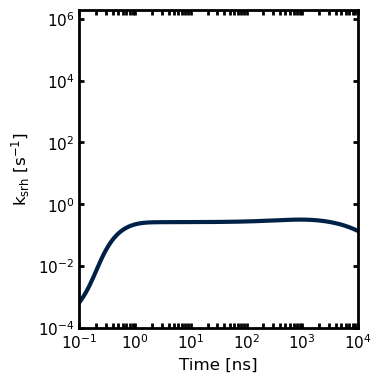

In [131]:
fig_two = plt.figure(figsize=(figure_width*centimeters, figure_width/2*centimeters))
plt.subplots_adjust(hspace=0, wspace=0.3)
gs_two = gridspec.GridSpec(1, 2)


ax_right = fig_two.add_subplot(gs_two[0, 1])
#ax_right.set_title('Diffusion + Recombination')
ax_right.set_xlim(1e-1,1e4)
ax_right.set_ylim(1e-4,2e6)
ax_right.set_xlabel('Time [ns]', fontsize=fontsize_base+1)
ax_right.set_ylabel('k$_{\mathrm{srh}}$ [s$^{-1}$]', fontsize=fontsize_base+1)
#ax_right.annotate('(b)' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)
ax_right.set_yscale('log')

for plot_name in [ax_right]:
    for axis in ['top', 'bottom', 'left', 'right']:
        plot_name.spines[axis].set_linewidth(2)
    plot_name.tick_params(bottom=True,top=True,left=True,right=True,
                   direction='in',width=2, length=3.5, which='both', labelsize=fontsize_base, zorder=2000)


################# LOAD DATA #####################

t_test_steps = len(time)

k_nr_bulk = kc_p*p_dens/(n_dens + kc_p/kc_n*p_dens + 2.65e18*np.exp(-trap_depth/(8.6e-5*292)))*1e12

k_nr_bulk_mean = np.median(k_nr_bulk,axis=1)

ax_right.plot(time, k_nr_bulk_mean, c=base_color, linewidth=3)
ax_right.set_xscale('log')
plt.plot()


df = pd.DataFrame()

df['time'] = time
df['k_nr_bulk_mean'] = k_nr_bulk_mean

savefolder = r'C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2024_01_16_Bayes_Simulated_Seongrok_k-obs'
dataname = f'simulated_k-obs_highestmob_shallow'

df.to_csv(f'{savefolder}/{dataname}.txt', sep='\t', index=False)
print(np.max(1e12*p_dens/(n_dens + kc_p/kc_n*p_dens + 2.65e18*np.exp(-trap_depth/(8.6e-5*292)))))

'''
for i in range(1, t_test_steps):
    if i == 999:
        color = base_color
        alpha = 0.8
        lw = 2
        zorder = 1000
    else:
        color= color_scheme[0]
        alpha = 0.1
        lw = 2
        zorder = 0    
    
    #ax_left.plot(z_coord*1e7,k_nr_bulk[0,:,i],c=color, alpha = alpha, lw=lw, zorder=zorder)
    #ax_left.annotate(str(str(np.round(time[i],1)) + " ns"),[0.6, 0.8], xycoords='axes fraction', fontsize=fontsize_base+2, backgroundcolor="w")    
    
    ax_right.scatter(time[i], np.mean(k_nr_bulk[0,:,i]),c=color)
    
    #plt.yscale('log')    
'''

In [638]:
print(PL_simulated)

[[1.00000000e+00]
 [1.00000000e+00]
 [9.99701085e-01]
 ...
 [4.51861231e-05]
 [4.50089004e-05]
 [4.48322000e-05]]


ValueError: x and y must have same first dimension, but have shapes (120,) and (10000, 1)

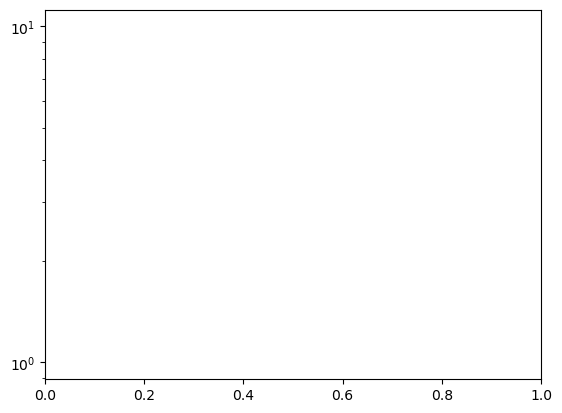

In [637]:
plt.semilogy(z_coord, PL_simulated)

# Figure(s) for the Bayes-paper

In [ ]:
S1 = [0.1] #cm s-1
S2 = [0.1] #cm s-1
Mobility= 0.1 #cm2 V-1s-1
S_mix = [0] # or 1

Fluence = 5e10   #cm-2
Surface = [0]   # 1 or something else
alpha = [1e5]  #cm-1
Reflect = [0.25, 0.2] # -
Reabs = [1, 1]   #cm
Thickness = 500   #nm

k_rad = 1e-10   #cm3 s-1
k_nr = 1e5   #s-1
n_eq = 1e13   #cm-3 
trap_depth = 0.6   #eV

time = np.linspace(0,500,500) #ns

#Mobility_list = [10, 1, 0.1, 0.01]
#PL_sim_Mobility = []
#S2_list = [1000, 100, 10, 1] 
#PL_sim_S2 = []
#k_rad_list = [1e-8, 1e-9, 1e-10, 1e-11]
#PL_sim_krad = []
#k_nr_list = [1e8, 1e7, 1e6, 1e5]
#PL_sim_knr = []
#trap_depth_list = [0.8, 0.4, 0.2, 0.1]
#PL_sim_trapd = []
#n_eq_test_list = [1e13, 1e14, 1e15, 1e16]
#PL_sim_neq = []
#S1_list = [1000, 100, 10, 1] 
#PL_sim_S1 = []
Rabs_list = [[1,1e3],[1,1e5],[1,1e6],[1,1e7]] 
PL_sim_Reabs = []


for value in Rabs_list:
    
    Reabs = value
    
    PL_simulated, n_diff_only, n_diff_recomb, z_coord = bayes_simulation(time, Fluence, Surface, Thickness, alpha, Reflect, Reabs, S1, S2, Mobility, S_mix, k_rad, k_nr, n_eq, trap_depth)
    #PL_sim_Mobility.append(PL_simulated.eval())
    #PL_sim_S2.append(PL_simulated.eval())
    #PL_sim_krad.append(PL_simulated.eval())
    #PL_sim_knr.append(PL_simulated.eval())
    #PL_sim_trapd.append(PL_simulated.eval())
    #PL_sim_neq.append(PL_simulated.eval())
    #PL_sim_S1.append(PL_simulated.eval())
    PL_sim_Reabs.append(PL_simulated.eval())

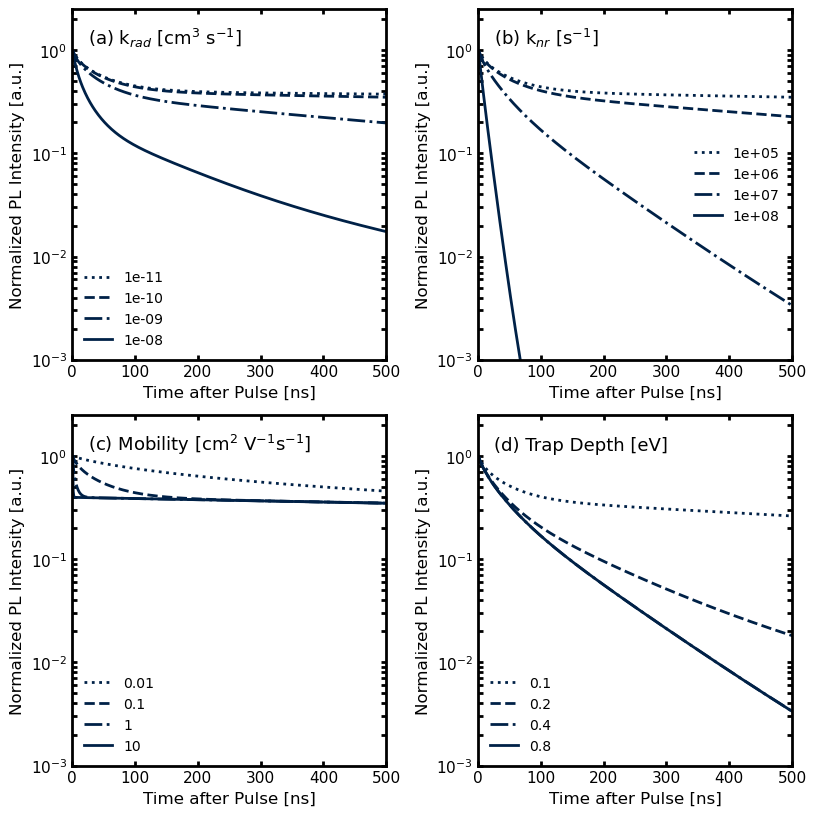

In [ ]:
fig_three_2 = plt.figure(figsize=(figure_width*centimeters, figure_width*centimeters))
plt.subplots_adjust(wspace=0.2, hspace=0)
gs_three_2 = gridspec.GridSpec(2, 2)

ax_topleft = fig_three_2.add_subplot(gs_three_2[1, 0])
ax_topleft.set_xlim(0,500)
ax_topleft.set_ylim(1e-3,2.5)
ax_topleft.set_yscale('log')
ax_topleft.set_xlabel('Time after Pulse [ns]', fontsize=fontsize_base+1)
ax_topleft.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
ax_topleft.annotate('(c) Mobility [cm$^2$ V$^{-1}$s$^{-1}$]' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)

ax_topright = fig_three_2.add_subplot(gs_three_2[1, 1])
ax_topright.set_xlim(0,500)
ax_topright.set_ylim(1e-3,2.5)
ax_topright.set_yscale('log')
#ax_topright.set_xscale('log')

ax_topright.set_xlabel('Time after Pulse [ns]', fontsize=fontsize_base+1)
ax_topright.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
ax_topright.annotate('(d) Trap Depth [eV]' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)

ax_bottomleft = fig_three_2.add_subplot(gs_three_2[0, 0])
ax_bottomleft.set_xlim(0,500)
ax_bottomleft.set_ylim(1e-3,2.5)
ax_bottomleft.set_yscale('log')
ax_bottomleft.set_xlabel('Time after Pulse [ns]', fontsize=fontsize_base+1)
ax_bottomleft.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
ax_bottomleft.annotate('(a) k$_{rad}$ [cm$^3$ s$^{-1}$]' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)


ax_bottomright = fig_three_2.add_subplot(gs_three_2[0, 1])
ax_bottomright.set_xlim(0,500)
ax_bottomright.set_ylim(1e-3,2.5)
ax_bottomright.set_yscale('log')
#ax_bottomright.set_xscale('log')
ax_bottomright.set_xlabel('Time after Pulse [ns]', fontsize=fontsize_base+1)
ax_bottomright.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
ax_bottomright.annotate('(b) k$_{nr}$ [s$^{-1}$]' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)


################# LOAD DATA #####################

################ top left #########################
legend_elements_topleft = []
legend_elements_topright = []
legend_elements_bottomleft = []
legend_elements_bottomright = []


for i in np.arange(4):
    ax_topleft.plot(time, np.array(PL_sim_Mobility[i]), color=base_color, linestyle = line_type_list[i], lw=2)
    legend_elements_topleft.append(Line2D([0], [0], marker=None ,color=base_color, lw=2, linestyle = line_type_list[3-i],label=Mobility_list[3-i]))
    
  
    ax_topright.plot(time, np.array(PL_sim_trapd[i]), color=base_color, linestyle = line_type_list[i], lw=2)
    legend_elements_topright.append(Line2D([0], [0], marker=None ,color=base_color, lw=2, linestyle = line_type_list[3-i],label=trap_depth_list[3-i]))

    ax_bottomleft.plot(time, np.array(PL_sim_krad[i]), color=base_color, linestyle = line_type_list[i], lw=2)
    legend_elements_bottomleft.append(Line2D([0], [0], marker=None ,color=base_color, lw=2, linestyle = line_type_list[3-i],label=k_rad_list[3-i]))
    
    ax_bottomright.plot(time, np.array(PL_sim_knr[i]), color=base_color, linestyle = line_type_list[i], lw=2)
    legend_elements_bottomright.append(Line2D([0], [0], marker=None ,color=base_color, lw=2, linestyle = line_type_list[3-i],label=str("{:.0e}".format(k_nr_list[3-i]))))




#####################################

#####################################
############### Legend #############

ax_topleft.legend(handles=legend_elements_topleft, frameon=False, title_fontsize=fontsize_base)
ax_topright.legend(handles=legend_elements_topright, frameon=False, title_fontsize=fontsize_base, loc='lower left')
ax_bottomleft.legend(handles=legend_elements_bottomleft, frameon=False, title_fontsize=fontsize_base)
ax_bottomright.legend(handles=legend_elements_bottomright, frameon=False, title_fontsize=fontsize_base)


############################################
################## Finishing the Figure ###################
for plot_name in [ax_topleft, ax_topright, ax_bottomleft, ax_bottomright]:
    for axis in ['top', 'bottom', 'left', 'right']:
        plot_name.spines[axis].set_linewidth(2)
    plot_name.tick_params(bottom=True,top=True,left=True,right=True,
                   direction='in',width=2, length=3.5, which='both', labelsize=fontsize_base, zorder=2000)

    
plt.tight_layout()
savefolder = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\Thesis\Figures\6_"
figurename = 'fig_validation_1'
#plt.savefig(f'{savefolder}/{figurename}.pdf', format='pdf', dpi=300)
#plt.savefig(f'{savefolder}/{figurename}.png', format='png', dpi=300, transparent=True)

plt.show()

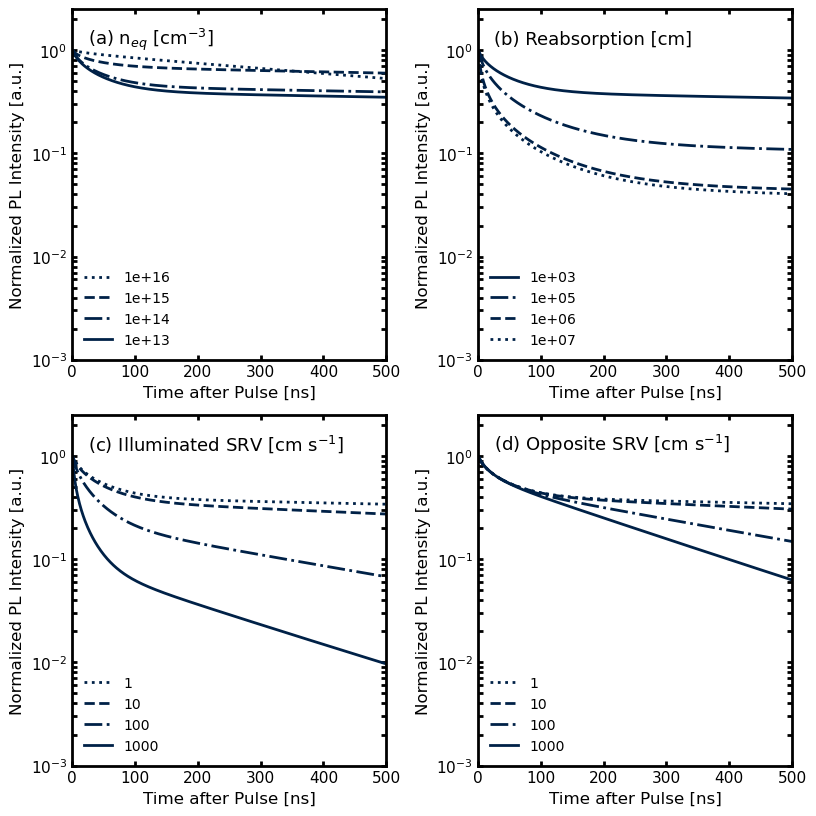

In [ ]:
fig_three_2 = plt.figure(figsize=(figure_width*centimeters, figure_width*centimeters))
plt.subplots_adjust(wspace=0.2, hspace=0)
gs_three_2 = gridspec.GridSpec(2, 2)

ax_topleft = fig_three_2.add_subplot(gs_three_2[1, 0])
ax_topleft.set_xlim(0,500)
ax_topleft.set_ylim(1e-3,2.5)
ax_topleft.set_yscale('log')
ax_topleft.set_xlabel('Time after Pulse [ns]', fontsize=fontsize_base+1)
ax_topleft.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
ax_topleft.annotate('(c) Illuminated SRV [cm s$^{-1}$]' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)

ax_topright = fig_three_2.add_subplot(gs_three_2[1, 1])
ax_topright.set_xlim(0,500)
ax_topright.set_ylim(1e-3,2.5)
ax_topright.set_yscale('log')
#ax_topright.set_xscale('log')

ax_topright.set_xlabel('Time after Pulse [ns]', fontsize=fontsize_base+1)
ax_topright.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
ax_topright.annotate('(d) Opposite SRV [cm s$^{-1}$]' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)


ax_bottomleft = fig_three_2.add_subplot(gs_three_2[0, 0])
ax_bottomleft.set_xlim(0,500)
ax_bottomleft.set_ylim(1e-3,2.5)
ax_bottomleft.set_yscale('log')
ax_bottomleft.set_xlabel('Time after Pulse [ns]', fontsize=fontsize_base+1)
ax_bottomleft.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
ax_bottomleft.annotate('(a) n$_{eq}$ [cm$^{-3}$]' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)


ax_bottomright = fig_three_2.add_subplot(gs_three_2[0, 1])
ax_bottomright.set_xlim(0,500)
ax_bottomright.set_ylim(1e-3,2.5)
ax_bottomright.set_yscale('log')
#ax_bottomright.set_xscale('log')
ax_bottomright.set_xlabel('Time after Pulse [ns]', fontsize=fontsize_base+1)
ax_bottomright.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
ax_bottomright.annotate('(b) Reabsorption [cm]' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)


################# LOAD DATA #####################

################ top left #########################
legend_elements_topleft = []
legend_elements_topright = []
legend_elements_bottomleft = []
legend_elements_bottomright = []


for i in np.arange(4):
    ax_topleft.plot(time, np.array(PL_sim_S2[i]), color=base_color, linestyle = line_type_list[i], lw=2)
    legend_elements_topleft.append(Line2D([0], [0], marker=None ,color=base_color, lw=2, linestyle = line_type_list[3-i],label=S2_list[3-i]))
    
    ax_topright.plot(time, np.array(PL_sim_S1[i]), color=base_color, linestyle = line_type_list[i], lw=2)
    legend_elements_topright.append(Line2D([0], [0], marker=None ,color=base_color, lw=2, linestyle = line_type_list[3-i],label=S1_list[3-i]))

    ax_bottomright.plot(time, np.array(PL_sim_Reabs[i]), color=base_color, linestyle = line_type_list[i], lw=2)
    legend_elements_bottomright.append(Line2D([0], [0], marker=None ,color=base_color, lw=2, linestyle = line_type_list[i],label=str("{:.0e}".format(Rabs_list[i][1]))))
    
    ax_bottomleft.plot(time, np.array(PL_sim_neq[i]), color=base_color, linestyle = line_type_list[i], lw=2)
    legend_elements_bottomleft.append(Line2D([0], [0], marker=None ,color=base_color, lw=2, linestyle = line_type_list[3-i],label=str("{:.0e}".format(n_eq_test_list[3-i]))))




#####################################

#####################################
############### Legend #############

ax_topleft.legend(handles=legend_elements_topleft, frameon=False, title_fontsize=fontsize_base)
ax_topright.legend(handles=legend_elements_topleft, frameon=False, title_fontsize=fontsize_base)
ax_bottomleft.legend(handles=legend_elements_bottomleft, frameon=False, title_fontsize=fontsize_base, loc='lower left')
ax_bottomright.legend(handles=legend_elements_bottomright, frameon=False, title_fontsize=fontsize_base)


############################################
################## Finishing the Figure ###################
for plot_name in [ax_topleft, ax_topright, ax_bottomleft, ax_bottomright]:
    for axis in ['top', 'bottom', 'left', 'right']:
        plot_name.spines[axis].set_linewidth(2)
    plot_name.tick_params(bottom=True,top=True,left=True,right=True,
                   direction='in',width=2, length=3.5, which='both', labelsize=fontsize_base, zorder=2000)

    
plt.tight_layout()
savefolder = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\Thesis\Figures\6_"
figurename = 'fig_validation_2'
plt.savefig(f'{savefolder}/{figurename}.pdf', format='pdf', dpi=300)
plt.savefig(f'{savefolder}/{figurename}.png', format='png', dpi=300, transparent=True)

plt.show()

In [ ]:
print(np.shape(Rabs_list))

(4, 2)


In [ ]:
fig_two = plt.figure(figsize=(figure_width*centimeters, figure_width/2*centimeters))
plt.subplots_adjust(hspace=0, wspace=0.3)
gs_two = gridspec.GridSpec(1, 2)

ax_left = fig_two.add_subplot(gs_two[0, 0])
ax_left.set_xlim(0,500)
ax_left.set_title('Only Diffusion')
ax_left.set_ylim(5e13,5e15)
ax_left.set_xlabel('z-coordinate [nm]', fontsize=fontsize_base+1)
ax_left.set_ylabel('Charge Carrier density [cm$^-3$]', fontsize=fontsize_base+1)
ax_left.annotate('(a)' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)
ax_left.set_yscale('log')

ax_right = fig_two.add_subplot(gs_two[0, 1])
ax_right.set_title('Diffusion + Recombination')
ax_right.set_xlim(0,500)
ax_right.set_ylim(5e13,5e15)
ax_right.set_xlabel('z-coordinate [nm]', fontsize=fontsize_base+1)
ax_right.set_ylabel('Charge Carrier density [cm$^-3$]', fontsize=fontsize_base+1)
ax_right.annotate('(b)' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)
ax_right.set_yscale('log')

for plot_name in [ax_left, ax_right]:
    for axis in ['top', 'bottom', 'left', 'right']:
        plot_name.spines[axis].set_linewidth(2)
    plot_name.tick_params(bottom=True,top=True,left=True,right=True,
                   direction='in',width=2, length=3.5, which='both', labelsize=fontsize_base, zorder=2000)


################# LOAD DATA #####################
savefolder = r'C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\Thesis\Figures\6_'

'''
from matplotlib.animation import FuncAnimation 
   
line, = ax_left.plot([], [], lw = 2, color='grey') 
   
def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):
    
    if i == 999:
        color = base_color
        alpha = 0.8
        lw = 3
        zorder = 1000
    else:
        color= color_scheme[0]
        alpha = 0.1
        lw = 2
        zorder = 0

    ax_left.plot(z_coord*1e7, n_diff_only[0,:,i], color=color,alpha=alpha, lw=lw, zorder=zorder) 
    ax_left.annotate(str(str(np.round(time[i],1)) + " ns"),[0.6, 0.8], xycoords='axes fraction', fontsize=fontsize_base+2, backgroundcolor="w")
    
    ax_right.plot(z_coord*1e7, n_diff_recomb[0,:,i], color=color,alpha=alpha, lw=lw, zorder=zorder) 
    ax_right.annotate(str(str(np.round(time[i],1)) + " ns"),[0.6, 0.8], xycoords='axes fraction', fontsize=fontsize_base+2, backgroundcolor="w")

    return line,

anim = FuncAnimation(fig_two, animate, init_func = init,
                     frames = 1000, interval = 1, blit = True)
  

videoname = str('Simulation_video')
anim.save(f'{savefolder}/{videoname}.mp4', 
          writer = 'ffmpeg', fps = 60, dpi=300)



t_test_min = time.min()
t_test_steps = len(time)
'''

for i in range(1, t_test_steps):
    if i == 999:
        color = base_color
        alpha = 0.8
        lw = 2
        zorder = 1000
    else:
        color= color_scheme[0]
        alpha = 0.1
        lw = 2
        zorder = 0    
        
    ax_left.plot(z_coord*1e7,n_diff_only[0,:,i],c=color, alpha = alpha, lw=lw, zorder=zorder)
    ax_left.annotate(str(str(np.round(time[i],1)) + " ns"),[0.6, 0.8], xycoords='axes fraction', fontsize=fontsize_base+2, backgroundcolor="w")
    
    ax_right.plot(z_coord*1e7,n_diff_recomb[0,:,i],c=color, alpha = alpha, lw=lw, zorder=zorder)
    ax_right.annotate(str(str(np.round(time[i],1)) + " ns"),[0.6, 0.8], xycoords='axes fraction', fontsize=fontsize_base+2, backgroundcolor="w")

    
    
figurename = str('Simulation_')
#plt.savefig(f'{savefolder}/{figurename}.pdf', format='pdf', dpi=300, transparent=True)

    
#plt.yscale('log')    


## This is a Figure for the Bayes Paper 

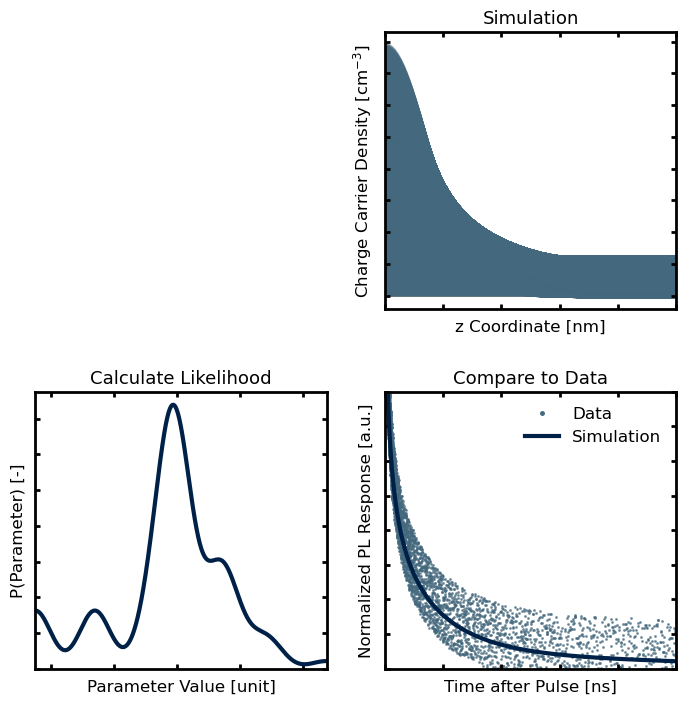

In [640]:
fig_three_2 = plt.figure(figsize=(figure_width*centimeters, figure_width*centimeters))
gs_three_2 = gridspec.GridSpec(2, 2, hspace=0.3)

ax_topleft = fig_three_2.add_subplot(gs_three_2[0, 1])
ax_topleft.set_title('Simulation', fontsize=fontsize_base+2)
ax_topleft.set_xlim(0,500)
ax_topleft.set_xticklabels("")
ax_topleft.set_yticklabels("")
#ax_topleft.set_ylim(0,2.3)
ax_topleft.set_xlabel('z Coordinate [nm]', fontsize=fontsize_base+1)
ax_topleft.set_ylabel('Charge Carrier Density [cm$^{-3}$]', fontsize=fontsize_base+1)

ax_topright = fig_three_2.add_subplot(gs_three_2[1, 1])
ax_topright.set_title('Compare to Data', fontsize=fontsize_base+2)
ax_topright.set_xlim(0,100)
ax_topright.set_ylim(2e-1,1)
ax_topright.set_xlabel('Time after Pulse [ns]', fontsize=fontsize_base+1)
ax_topright.set_ylabel('Normalized PL Response [a.u.]', fontsize=fontsize_base+1)


ax_bottomright = fig_three_2.add_subplot(gs_three_2[1, 0])
ax_bottomright.set_title('Calculate Likelihood', fontsize=fontsize_base+2)

#ax_bottomright.set_xlim(150,2500)
#ax_bottomright.set_ylim(0,2.3)
ax_bottomright.set_xlabel('Parameter Value [unit]', fontsize=fontsize_base+1)
ax_bottomright.set_ylabel('P(Parameter) [-]', fontsize=fontsize_base+1)
ax_bottomright.set_xticklabels("")
ax_bottomright.set_yticklabels("")

################# LOAD DATA #####################

#File_name = r"\\physics.ox.ac.uk\dfs\home\kober-czerny\00_Oxford_PhD\00_Snaith Group\Jongchul_Paper\TPC_Decay\TPC_Jong1_D1C1S1_670_processed.txt"
#Raw_File = pd.read_csv(File_name, sep="\t")
#values = Raw_File['name_of_parameter'].values

t_test_min = time.min()
t_test_steps = len(time)


for i in range(1, t_test_steps):
    if i == 999:
        color = base_color
        alpha = 0.8
        lw = 2
        zorder = 1000
    else:
        color= color_scheme[0]
        alpha = 0.08
        lw = 3
        zorder = 0    
        
    ax_topleft.plot(z_coord*1e7,n_diff_only[0,:,i],c=color, alpha = alpha, lw=lw, zorder=zorder)
    
#####################################

PL_errors = np.zeros(np.shape(PL_simulated))

for i in range(len(time)):
    PL_errors[i,:] = 0.2*random.random()-0.08

    
ax_topright.scatter(time,PL_simulated+PL_errors, color=color_scheme[0], alpha=0.6,marker='.',s=5)

ax_topright.plot(time,PL_simulated, color=base_color, lw = 3)

#ax_topright.set_yscale('log')    
ax_topright.set_xticklabels("")
ax_topright.set_yticklabels("")
################# PLOTTING DATA #####################

File_name = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_07_24_Bayes_David_TGB\500_mobilities.txt"
Raw_File = pd.read_csv(File_name, sep="\t", header=None)
Mobilities = Raw_File[0].values

def plot_kernel_1D(a):
    x_a = np.logspace(np.log10(np.min(a)),np.log10(np.max(a)),1000)
    kernel_1d = stats.gaussian_kde(a)(x_a)
    return x_a, kernel_1d


ax_bottomright.plot(plot_kernel_1D(Mobilities)[0],plot_kernel_1D(Mobilities)[1], color=base_color, lw = 3)
ax_bottomright.set_xlim(np.min(plot_kernel_1D(Mobilities)[0]), np.max(plot_kernel_1D(Mobilities)[0]))
ax_bottomright.set_ylim(0,None)


#ax_bottomright.plot(x,y1, linestyle=line_type_list[0], color=base_color, linewidth=2)
#ax_bottomright.plot(x,y2, linestyle=line_type_list[1], color=highlight_color, linewidth=2)


#ax_topright.plot(x,y3, linestyle=line_type_list[0], color=base_color, linewidth=2)
#ax_topright.plot(x,y4, linestyle=line_type_list[1], color=highlight_color, linewidth=2)



#####################################
############### Legend #############


legend_elements_topright = []

legend_elements_topright.append(Line2D([0], [0], marker='.', markersize=5 ,color=color_scheme[0], lw=0, label=r"Data"))
legend_elements_topright.append(Line2D([0], [0], marker=None, color=base_color, lw=3, label=r"Simulation"))

ax_topright.legend(handles=legend_elements_topright, frameon=False, fontsize=fontsize_base+1, loc='upper right')
    



############################################
################## Finishing the Figure ###################
for plot_name in [ax_topleft, ax_topright, ax_bottomright]:
    for axis in ['top', 'bottom', 'left', 'right']:
        plot_name.spines[axis].set_linewidth(2)
    plot_name.tick_params(bottom=True,top=True,left=True,right=True,
                   direction='in',width=2, length=3.5, which='both', labelsize=fontsize_base, zorder=2000)

    

#plt.tight_layout()
#savefolder = f''
figurename = 'fig_intro_graphs'
#plt.savefig(f'{savefolder}/{figurename}.pdf', format='pdf', dpi=300)
#plt.savefig(f'{savefolder}/{figurename}.png', format='png', dpi=300, transparent=True)

plt.show()

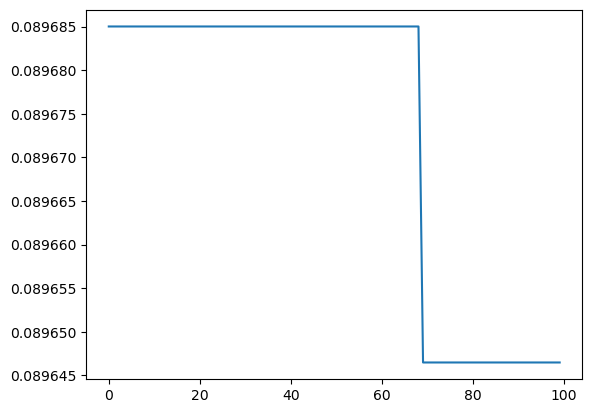

# PLQE Simulation

In [2]:
"""This is the Diffusion model in PyTensor

It is mainly based on:  J. Appl. Phys. 116, 123711 (2014).
The important equations are marked.
In addition I took inspiration from:
https://www.nature.com/articles/s41598-019-41716-x#Sec16
https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-017-02670-2/MediaObjects/41467_2017_2670_MOESM1_ESM.pdf
and 
https://www.sciencedirect.com/science/article/pii/S2542435122004202#sec6.2

"""

def plqe_simulation(Generation_no_reflectance, Thickness, Reflectance, S1, S2, k_rad, kc_n, trap_depth, k1, Reabs, k3):
    
    Generation_rate = Generation_no_reflectance*(1-Reflectance)

    ne_1 = 1e18 * np.exp(-trap_depth*1.60218e-19/(1.380649e-23 * 292))
    
    def rate_equations(vars, Gen, kc_n, ne_1, k1, krad,  S1, S2):            
            ### Pseudo-Equilibrium at each time-point
            n_dens = vars

            dn_dt = Gen - (krad)*(n_dens**2) - kc_n*n_dens**2/(2*n_dens + ne_1)  - (S1+S2)/(Thickness*1e-7)*n_dens
            
            return dn_dt

    
    vars_ss = root(rate_equations, 1e12, method='hybr', args=(Generation_rate, kc_n, ne_1, k1, k_rad, S1, S2))
    
        
    def PLQE_calc(vars_ss, kc_n, ne_1, k1, krad, S1, S2, Reabs, k3):
        n_dens = vars_ss

        #PLQE_int = krad*(n_dens*n_dens + n_dens*n_eq)/(krad*(n_dens*n_dens + p_dens*n_eq) + kc_n*((n_dens)*(1-f_trap) - f_trap*ne_1) + kc_n*(p_dens)*f_trap  + n_dens*(S1+S2)/(Thickness*1e-7))
        #PLQE_int = krad*(n_dens*n_dens + 2*n_dens*n_eq)/(krad*(n_dens*n_dens + 2*n_dens*n_eq) + kc_n*f_trap*n_dens + (S1+S2)/(Thickness*1e-7)*n_dens)
        
        PLQE_int = (krad*(n_dens))/(krad*(n_dens) + kc_n*n_dens/(2*n_dens + ne_1) + (S1 + S2)/(Thickness*1e-7) + k3*n_dens**2)

        PLQE_ext = PLQE_int*Reabs/(1-PLQE_int+ PLQE_int*Reabs)

        return PLQE_ext
    
    PLQE_ext = PLQE_calc(vars_ss.x, kc_n, ne_1, k1, k_rad, S1, S2, Reabs, k3)
    return PLQE_ext


In [16]:
Thickness = 600
alpha = 2e5

alpha_coeff = 3e5

data_folder_nc = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_07_20_Bayes_Seongrok_FAPI"

trace_name = r"Seo_FAPI_trace_2024-02-21_080208.nc"
trace = az.from_netcdf(f'{data_folder_nc}/{trace_name}')


diff_factor = trace.posterior.Diffusion_coefficient.values[:,-1000:].ravel()
Diffusion_coeff = 1e-4*(1+diff_factor)#2.5*1/(1+diff_factor)
Mobilities = Diffusion_coeff/(1.380649e-23*292/1.6021766e-19)


## Recombination
k_rad_factor_values = trace.posterior.k_rad_model.values[:,-1000:].ravel()
k_rad_model_values = 1e-9*1/(1+k_rad_factor_values)

n_eq_model_values = trace.posterior.n_eq_model.values[:,-1000:].ravel()

kc_n_factor_values = trace.posterior.kc_n_rates.values[:,-1000:].ravel()
kc_n_model_values = kc_n_factor_values#1e7*1/(1+kc_n_factor_values)

trap_depth_model_values = trace.posterior.trap_depth.values[:,-1000:].ravel()*0.5

## Reabsorption
Reabs_1 = trace.posterior.alpha_N_RV.values[:,:,0].ravel()
Reabs_2 = trace.posterior.alpha_N_RV.values[:,:,1].ravel()
#Reabs_edge = trace.posterior.Reabs_edge.values[:,-500:].ravel()
Reabs_fact = (np.exp(-(Reabs_2)*Thickness*1e-7) + np.exp(-(Reabs_1)*Thickness*1e-7))/2


## Other
PL_err_values = trace.posterior.PL_err.values[:,-1000:].ravel()

#S_sumprod_factor_power_values = trace.posterior.S_sumprod_ratio_model.values[:,-1000:].ravel()
#S_sumprod_factor_model_values =  10**(-3*S_sumprod_factor_power_values+0.01)
S_sumprod_factor_power_values = trace.posterior.S_sumprod_ratio_model[:,-1000:].values.ravel()
S_sumprod_factor_power_values[S_sumprod_factor_power_values >= 1] = 1
S_sumprod_factor_model_values = S_sumprod_factor_power_values

S_sum_power_values = trace.posterior.S_sum_model.values[:,-1000:].ravel()
S_sum_model_values = 1*(1+S_sum_power_values)

S_mix_model_values = trace.posterior.S_mix.values[:,-1000:].ravel()

### Calculated Parameters
S_a = ((S_sum_model_values - np.sqrt(S_sum_model_values**2 *(1 - S_sumprod_factor_model_values)))/2)
S_b = (S_sum_model_values + np.sqrt(S_sum_model_values**2 *(1 - S_sumprod_factor_model_values)))/2

marker = np.where(S_a < 0.1)

S_a[marker] = 0
S_b[marker] = S_sum_model_values[marker]

S_1 =  S_a*(1-S_mix_model_values) + S_b*S_mix_model_values
S_2 =  S_b*(1-S_mix_model_values) + S_a*S_mix_model_values

In [17]:



File_name = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\PLQE\2023_07_20_Bayes_Seongrok_FAPI\Data_processed\PLQEs.csv"
Raw_File = pd.read_csv(File_name)


Power = Raw_File["# Power(W)"].values/0.0691/0.15
Data = Raw_File["Seo_FAPI_1_PLQE"].values


Generation_Rates = Power*445*1e-9/(6.63e-34*299792458)*(1-np.exp(-Thickness*1e-7*alpha))


one_sun_val = 1e17
one_sun_marker = np.where(Generation_Rates/one_sun_val >= 0.8)[0][0]
#plt.scatter(Generation_Rates, Data)





# Perov on Glass

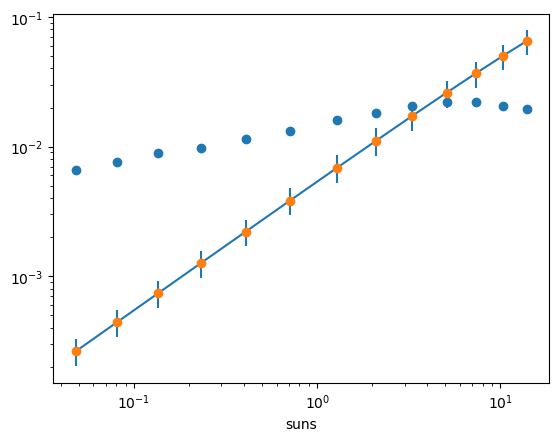

In [19]:
PLQE_all = []
S1_list = []
S2_list = []
Mobility_list = []
k_rad_list = []
k_nr_list = []
n_eq_list = []
trap_depth_list = []
PL_corr_list = ()

okay=0
while okay < 1:

    for sample in np.arange(500):
        rand_pick = random.randint(0,len(k_rad_model_values)-1)
        S1 = S_sum_model_values[rand_pick]
        S1_list.append(S1)
        S2 = S_2[rand_pick]
        S2_list.append(S2)
        Mobility = Mobilities[rand_pick]
        Mobility_list.append(Mobility)
        k_rad = k_rad_model_values[rand_pick]
        k_rad_list.append(k_rad)
        k_nr = kc_n_model_values[rand_pick]
        k_nr_list.append(k_nr)
        n_eq = n_eq_model_values[rand_pick]
        n_eq_list.append(n_eq)
        trap_depth = trap_depth_model_values[rand_pick]
        trap_depth_list.append(trap_depth)
        Reabs = Reabs_fact[rand_pick]
        
        PLQE = ()

        for Generation in Generation_Rates:
            
            PLQE_i = plqe_simulation(Generation/(Thickness*1e-7), Thickness, 0.25, S1, 0, k_rad, k_nr, trap_depth, 0, Reabs, 0)
            
            PLQE = np.append(PLQE, PLQE_i)


        PLQE_corr = Data[one_sun_marker]/PLQE[one_sun_marker]
        PL_corr_list = np.append(PL_corr_list, PLQE_corr)

        corr_PLQE = PLQE#*PLQE_corr
        PLQE_all.append(corr_PLQE) 

    PLQE_mean = np.median(PLQE_all,axis=0)
    PLQE_q1 = PLQE_mean-np.quantile(PLQE_all,0.25, axis=0)
    PLQE_q3 = np.quantile(PLQE_all,0.75, axis=0)-PLQE_mean
    PLQE_error = np.vstack((PLQE_q1,PLQE_q3))


    PLQE_control = PLQE_mean[:one_sun_marker]/Data[:one_sun_marker]
        
    if np.median(PLQE_control) < 1000:
        okay=1
    else:
        okay=0
plt.errorbar(Generation_Rates/one_sun_val, PLQE_mean, yerr=PLQE_error)
plt.scatter(Generation_Rates/one_sun_val, Data)
plt.scatter(Generation_Rates/one_sun_val, PLQE_mean,zorder=1000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('suns')
plt.show()


# ETL - SnO2

C:\Users\kober-czerny\AppData\Local\Temp\ipykernel_10676\1882323445.py:30: RuntimeWarning: invalid value encountered in sqrt
  S_a = ((S_sum_model_valuesSnO2 - np.sqrt(S_sum_model_valuesSnO2**2 *(1 - S_sumprod_factor_model_valuesSnO2)))/2)
C:\Users\kober-czerny\AppData\Local\Temp\ipykernel_10676\1882323445.py:31: RuntimeWarning: invalid value encountered in sqrt
  S_b = (S_sum_model_valuesSnO2 + np.sqrt(S_sum_model_valuesSnO2**2 *(1 - S_sumprod_factor_model_valuesSnO2)))/2


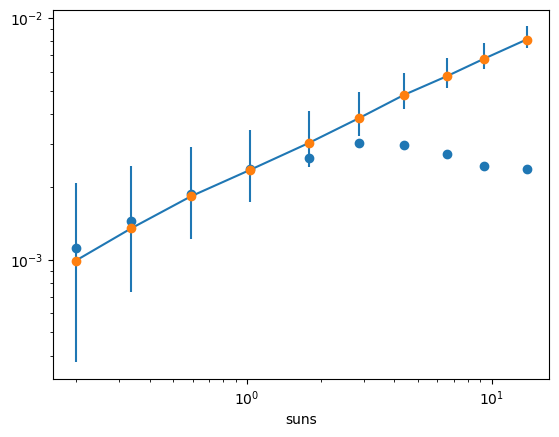

In [20]:
data_folder_nc = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_07_20_Bayes_Seongrok_FAPI"

trace_name = r"Seo_SnO2_trace_2024-02-21_021455.nc"
trace = az.from_netcdf(f'{data_folder_nc}/{trace_name}')

diff_factorSnO2 = trace.posterior.Diffusion_coefficient.values[:,-1000:].ravel()
Diffusion_coeffSnO2 = 1e-4*(1+diff_factorSnO2)
MobilitiesSnO2 = Diffusion_coeffSnO2/(1.380649e-23*292/1.6021766e-19)

## Recombination
k_rad_factor_valuesSnO2 = trace.posterior.k_rad_model.values[:,-1000:].ravel()
k_rad_model_valuesSnO2 = 1e-9*1/(1+k_rad_factor_valuesSnO2)

n_eq_model_valuesSnO2 = trace.posterior.n_eq_model.values[:,-1000:].ravel()

kc_n_factor_valuesSnO2 = trace.posterior.kc_n_rates.values[:,-1000:].ravel()
kc_n_model_valuesSnO2 = kc_n_factor_valuesSnO2#1e7*1/(1+kc_n_factor_valuesSnO2)

trap_depth_model_valuesSnO2 = trace.posterior.trap_depth.values[:,-1000:].ravel()*0.5

S_sumprod_factor_power_valuesSnO2 = trace.posterior.S_sumprod_ratio_model.values[:,-1000:].ravel()
S_sumprod_factor_model_valuesSnO2 = 10**(-3*S_sumprod_factor_power_valuesSnO2+0.01)

S_sum_power_valuesSnO2 = trace.posterior.S_sum_model.values[:,-1000:].ravel()
S_sum_model_valuesSnO2 = 1*(1+S_sum_power_valuesSnO2)

S_mix_model_valuesSnO2 = trace.posterior.S_mix.values[:,-1000:].ravel()

### Calculated Parameters
S_a = ((S_sum_model_valuesSnO2 - np.sqrt(S_sum_model_valuesSnO2**2 *(1 - S_sumprod_factor_model_valuesSnO2)))/2)
S_b = (S_sum_model_valuesSnO2 + np.sqrt(S_sum_model_valuesSnO2**2 *(1 - S_sumprod_factor_model_valuesSnO2)))/2
marker = np.where(S_a < 0.1)

S_a[marker] = 0
S_b[marker] = S_sum_model_values[marker]

S_1SnO2 =  S_a*(1-S_mix_model_valuesSnO2) + S_b*S_mix_model_valuesSnO2
S_2SnO2 =  S_b*(1-S_mix_model_valuesSnO2) + S_a*S_mix_model_valuesSnO2

## Reabsorption
Reabs_1_SnO2 = trace.posterior.alpha_N_RV.values[:,-1000:,0].ravel()
Reabs_2_SnO2 = trace.posterior.alpha_N_RV.values[:,-1000:,1].ravel()
Reabs_fact_SnO2 = np.exp(-(Reabs_1_SnO2)*Thickness*1e-7)

Data = Raw_File["Seo_FAPI_1_PLQE"].values

Power_SnO2 = Raw_File["Power(W)-2"].values /0.0691/0.15
Data_SnO2 = Raw_File["Seo_FAPI_TiO2_SnO2_1_PLQE"].values

Generation_Rates_SnO2 = Power_SnO2*445*1e-9/(6.63e-34*299792458)*(1-np.exp(-Thickness*1e-7*alpha))


one_sun_val = 1e17
one_sun_marker_SnO2 = np.where(Generation_Rates_SnO2/one_sun_val >= 0.8)[0][0]

max_marker_SnO2 = np.argmax(Data_SnO2)




PLQE_allSnO2 = []
S1_listSnO2 = []
S2_listSnO2 = []
Mobility_listSnO2 = []
k_rad_listSnO2 = []
k_nr_listSnO2 = []
n_eq_listSnO2 = []
trap_depth_listSnO2 = []
PL_corrSnO2_list = []

okay=0
while okay < 1:

    for sample in np.arange(500):
        rand_pick = random.randint(0,len(k_rad_model_valuesSnO2)-1)
        S1 = S_sum_model_valuesSnO2[rand_pick]
        S1_listSnO2.append(S1)
        S2 = S_2SnO2[rand_pick]
        S2_listSnO2.append(S2)
        Mobility = MobilitiesSnO2[rand_pick]
        Mobility_listSnO2.append(Mobility)
        k_rad = k_rad_model_valuesSnO2[rand_pick]
        k_rad_listSnO2.append(k_rad)
        k_nr = kc_n_model_valuesSnO2[rand_pick]
        k_nr_listSnO2.append(k_nr)
        n_eq = n_eq_model_valuesSnO2[rand_pick]
        n_eq_listSnO2.append(n_eq)
        trap_depth = trap_depth_model_valuesSnO2[rand_pick]
        trap_depth_listSnO2.append(trap_depth)
        Reabs = Reabs_fact_SnO2[rand_pick]

        PLQE = []
        for Generation in Generation_Rates:

            PLQE.append(plqe_simulation(Generation/(Thickness*1e-7), Thickness, 0.25, S1, 0, k_rad, k_nr, trap_depth, 0, 0.6, 0))


        PLQE_corrSnO2 = Data_SnO2[one_sun_marker_SnO2]/PLQE[one_sun_marker_SnO2]
        PL_corrSnO2_list.append(PLQE_corrSnO2)
        corr_PLQE = PLQE#*PLQE_corrSnO2
        
        PLQE_allSnO2.append(corr_PLQE) 

    PLQE_meanSnO2 = np.median(PLQE_allSnO2,axis=0)
    PLQE_q1 = PLQE_meanSnO2-np.quantile(PLQE_allSnO2,0.25, axis=0)
    PLQE_q3 = np.quantile(PLQE_allSnO2,0.75, axis=0)-PLQE_meanSnO2
    PLQE_errorSnO2 = np.stack((PLQE_q1,PLQE_q3))
    
    PLQE_controlSnO2 = PLQE_meanSnO2[:one_sun_marker_SnO2]/Data_SnO2[:one_sun_marker_SnO2]
        
    if np.median(PLQE_controlSnO2) < 1000:
        okay=1
    else:
        okay=0
plt.errorbar(Generation_Rates_SnO2/one_sun_val, PLQE_meanSnO2[:,0], yerr=PLQE_errorSnO2[:,0])

plt.scatter(Generation_Rates_SnO2/one_sun_val, Data_SnO2)
plt.scatter(Generation_Rates_SnO2/one_sun_val, PLQE_meanSnO2[:,0],zorder=1000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('suns')
plt.show()


# HTL - Spiro

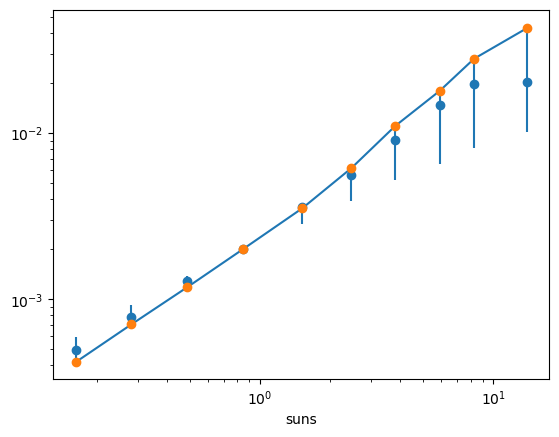

nan


In [10]:
data_folder_nc = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_07_20_Bayes_Seongrok_FAPI"

trace_name = r"Seo_Spiro_trace_2024-02-20_210406.nc"
trace = az.from_netcdf(f'{data_folder_nc}/{trace_name}')

diff_factorSpiro = trace.posterior.Diffusion_coefficient.values[:,-1000:].ravel()
Diffusion_coeffSpiro = 1e-4*(1+diff_factorSpiro)
MobilitiesSpiro = Diffusion_coeffSpiro/(1.380649e-23*292/1.6021766e-19)

## Recombination
k_rad_factor_valuesSpiro = trace.posterior.k_rad_model.values[:,-1000:].ravel()
k_rad_model_valuesSpiro = 1e-9*1/(1+k_rad_factor_valuesSpiro)

n_eq_model_valuesSpiro = trace.posterior.n_eq_model.values[:,-1000:].ravel()

kc_n_factor_valuesSpiro = trace.posterior.kc_n_rates.values[:,-1000:]
kc_n_model_valuesSpiro = kc_n_factor_valuesSpiro.ravel()

trap_depth_model_valuesSpiro = trace.posterior.trap_depth[:,-1000:].values.ravel()*0.5

#S_sumprod_factor_power_valuesSpiro = trace.posterior.S_sumprod_ratio_model[:,-1000:].values.ravel()
#S_sumprod_factor_model_valuesSpiro = 10**(-3*S_sumprod_factor_power_valuesSpiro+0.01)#0.9*1/(1+S_sumprod_factor_power_valuesSpiro)
S_sumprod_factor_power_valuesSpiro = trace.posterior.S_sumprod_ratio_model[:,-1000:].values.ravel()
S_sumprod_factor_power_valuesSpiro[S_sumprod_factor_power_valuesSpiro >= 1] = 1
S_sumprod_factor_model_valuesSpiro = S_sumprod_factor_power_valuesSpiro

S_sum_power_valuesSpiro = trace.posterior.S_sum_model.values[:,-1000:].ravel()
S_sum_model_valuesSpiro = 1*(1+S_sum_power_valuesSpiro)

S_mix_model_valuesSpiro = trace.posterior.S_mix.values[:,-1000:].ravel()

### Calculated Parameters
S_a = ((S_sum_model_valuesSpiro - np.sqrt(S_sum_model_valuesSpiro**2 *(1 - S_sumprod_factor_model_valuesSpiro)))/2)
S_b = (S_sum_model_valuesSpiro + np.sqrt(S_sum_model_valuesSpiro**2 *(1 - S_sumprod_factor_model_valuesSpiro)))/2

marker = np.where(S_a < 0.1)

S_a[marker] = 0
S_b[marker] = S_sum_model_values[marker]

S_1Spiro =  S_a*(1-S_mix_model_valuesSpiro) + S_b*S_mix_model_valuesSpiro
S_2Spiro =  S_b*(1-S_mix_model_valuesSpiro) + S_a*S_mix_model_valuesSpiro

## Reabsorption
Reabs_1_Spiro = trace.posterior.alpha_N_RV.values[:,:,0].ravel()
Reabs_2_Spiro = trace.posterior.alpha_N_RV.values[:,:,1].ravel()
Reabs_fact_Spiro = np.exp(-(Reabs_1_Spiro)*Thickness*1e-7)


Power_Spiro = Raw_File["Power(W)-1"].values/0.0691/0.15
Data_Spiro = Raw_File["Seo_FAPI_Spiro_1_PLQE"].values

Generation_Rates_Spiro = Power_Spiro*445*1e-9/(6.63e-34*299792458)*(1-np.exp(-Thickness*1e-7*alpha))


one_sun_val = 1e17
one_sun_marker_Spiro = np.where(Generation_Rates_Spiro/one_sun_val >= 0.8)[0][0]

max_marker_Spiro = np.argmax(Data_Spiro)




PLQE_allSpiro = []
S1_listSpiro = []
S2_listSpiro= []
Mobility_listSpiro = []
k_rad_listSpiro = []
k_nr_listSpiro = []
n_eq_listSpiro = []
trap_depth_listSpiro = []
PL_corrSpiro_list = []

okay=0
while okay < 1:

    for sample in np.arange(500):
        rand_pick = random.randint(0,len(k_rad_model_valuesSpiro)-1)
        S1 = S_sum_model_valuesSpiro[rand_pick]
        S1_listSpiro.append(S1)
        S2 = S_2Spiro[rand_pick]
        S2_listSpiro.append(S2)
        Mobility = MobilitiesSpiro[rand_pick]
        Mobility_listSpiro.append(Mobility)
        k_rad = k_rad_model_valuesSpiro[rand_pick]
        k_rad_listSpiro.append(k_rad)
        k_nr = kc_n_model_valuesSpiro[rand_pick]
        n_eq = n_eq_model_valuesSpiro[rand_pick]
        n_eq_listSpiro.append(n_eq)
        trap_depth = trap_depth_model_valuesSpiro[rand_pick]
        Reabs = Reabs_fact_Spiro[rand_pick]

        trap_depth_listSpiro.append(trap_depth)

        PLQE = []
        for Generation in Generation_Rates:

            PLQE.append(plqe_simulation(Generation/(Thickness*1e-7), Thickness, 0.25, S1, 0, k_rad, k_nr, trap_depth, 0, 1, 0))


        PLQE_corrSpiro = Data_Spiro[one_sun_marker_Spiro]/PLQE[one_sun_marker_Spiro]
        PL_corrSpiro_list.append(PLQE_corrSpiro)
        corr_PLQE = PLQE*PLQE_corrSpiro
        
        PLQE_allSpiro.append(corr_PLQE) 

    PLQE_meanSpiro = np.median(PLQE_allSpiro,axis=0)
    PLQE_q1 = PLQE_meanSpiro-np.quantile(PLQE_allSpiro,0.25, axis=0)
    PLQE_q3 = np.quantile(PLQE_allSpiro,0.75, axis=0)-PLQE_meanSpiro
    PLQE_errorSpiro = np.stack((PLQE_q1,PLQE_q3))

    PLQE_controlSpiro = PLQE_meanSpiro[:one_sun_marker_Spiro]/Data_Spiro[:one_sun_marker_Spiro]
        
    if np.median(PLQE_controlSpiro) < 1000:
        okay=1
    else:
        okay=0
plt.errorbar(Generation_Rates_Spiro/one_sun_val, PLQE_meanSpiro[:,0], yerr=PLQE_errorSpiro[:,:,0])

plt.scatter(Generation_Rates_Spiro/one_sun_val, Data_Spiro)
plt.scatter(Generation_Rates_Spiro/one_sun_val, PLQE_meanSpiro[:,0], zorder=1000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('suns')
plt.show()

print(np.median(k_nr_listSpiro))


In [23]:
print(np.median(k_rad))

8.49569290409601e-11


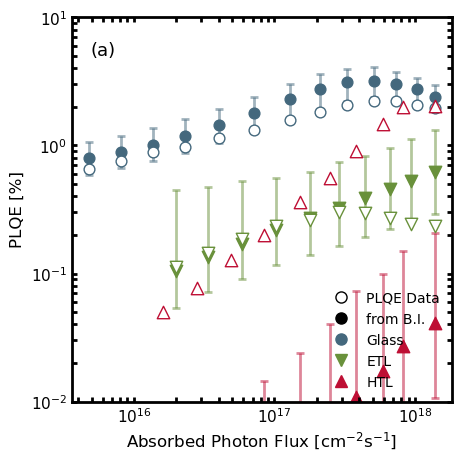

In [14]:
fig_three_2 = plt.figure(figsize=(12*centimeters, 12*centimeters))
plt.subplots_adjust(wspace=0.2, hspace=0)
gs_three_2 = gridspec.GridSpec(1, 1)

ax_topleft = fig_three_2.add_subplot(gs_three_2[0, 0])
#ax_topleft.set_xlim(150,2500)
ax_topleft.set_ylim(1e-2,1e1)
ax_topleft.set_xlabel('Absorbed Photon Flux [cm$^{-2}$s$^{-1}$]', fontsize=fontsize_base+1)
ax_topleft.set_ylabel('PLQE [%]', fontsize=fontsize_base+1)
ax_topleft.annotate('(a)' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)
ax_topleft.set_xscale('log')
ax_topleft.set_yscale('log')


################# LOAD DATA #####################

#File_name = r"\\physics.ox.ac.uk\dfs\home\kober-czerny\00_Oxford_PhD\00_Snaith Group\Jongchul_Paper\TPC_Decay\TPC_Jong1_D1C1S1_670_processed.txt"
#Raw_File = pd.read_csv(File_name, sep="\t")
#values = Raw_File['name_of_parameter'].values

################ TOP LEFT ######################

ax_topleft.errorbar(Generation_Rates, PLQE_mean*100, yerr=PLQE_error*100, markersize=1 ,fmt="o",  lw=2, capsize=3, capthick=2, color=color_scheme[0], zorder=-1000, alpha=0.5)
ax_topleft.scatter(Generation_Rates, PLQE_mean*100, marker='o',s=60 ,color=color_scheme[0],zorder=0)
ax_topleft.scatter(Generation_Rates, Data*100, marker='o', s=60, facecolor='w', color=color_scheme[0],zorder=100)

ax_topleft.errorbar(Generation_Rates_SnO2, PLQE_meanSnO2[:,0]*100, yerr=PLQE_errorSnO2[:,:,0]*100, markersize=1 ,fmt="o",  lw=2, capsize=3, capthick=2, color=color_scheme[1], zorder=-1000, alpha=0.5)
ax_topleft.scatter(Generation_Rates_SnO2, PLQE_meanSnO2[:,0]*100, marker='v', s=80,color=color_scheme[1],zorder=0)
ax_topleft.scatter(Generation_Rates_SnO2, Data_SnO2*100, marker='v', s=80, facecolor = 'w', color=color_scheme[1],zorder=100)


ax_topleft.errorbar(Generation_Rates_Spiro, PLQE_meanSpiro[:,0]*100, yerr=PLQE_errorSpiro[:,:,0]*100, markersize=1 ,fmt="o",  lw=2, capsize=3, capthick=2, color=color_scheme[3], zorder=-1000, alpha=0.5)
ax_topleft.scatter(Generation_Rates_Spiro, PLQE_meanSpiro[:,0]*100, marker='^', s=80,color=color_scheme[3],zorder=0)
ax_topleft.scatter(Generation_Rates_Spiro, Data_Spiro*100, marker='^', s=80, facecolor = 'w', color=color_scheme[3],zorder=100)



################# TOP RIGHT ##########################


legend_elements_topleft = []
legend_elements_left = []
legend_elements_right = []

legend_elements_topleft.append(Line2D([0], [0], marker="o", markersize=8 , markerfacecolor='w', color='black', lw=0 ,label="PLQE Data"))
legend_elements_topleft.append(Line2D([0], [0], marker="o", markersize=8 ,color='black', lw=0 ,label="from B.I."))
legend_elements_topleft.append(Line2D([0], [0], marker="o", markersize=8 ,color=color_scheme[0], lw=0 ,label="Glass"))
legend_elements_topleft.append(Line2D([0], [0], marker="v", markersize=8 ,color=color_scheme[1], lw=0 ,label="ETL"))
legend_elements_topleft.append(Line2D([0], [0], marker="^", markersize=8 ,color=color_scheme[3], lw=0 ,label="HTL"))



ax_topleft.legend(handles=legend_elements_topleft, frameon=False, title_fontsize=fontsize_base+1, loc="lower right")





############################################
################## Finishing the Figure ###################
for plot_name in [ax_topleft]:
    for axis in ['top', 'bottom', 'left', 'right']:
        plot_name.spines[axis].set_linewidth(2)
    plot_name.tick_params(bottom=True,top=True,left=True,right=True,
                   direction='in',width=2, length=3.5, which='both', labelsize=fontsize_base, zorder=2000)

    
plt.tight_layout()
savefolder = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\Thesis\Figures\6_"
figurename = 'fig_halfstacks_plqe'
#plt.savefig(f'{savefolder}/{figurename}.pdf', format='pdf', dpi=300)
#plt.savefig(f'{savefolder}/{figurename}.png', format='png', dpi=300, transparent=True)

plt.show()

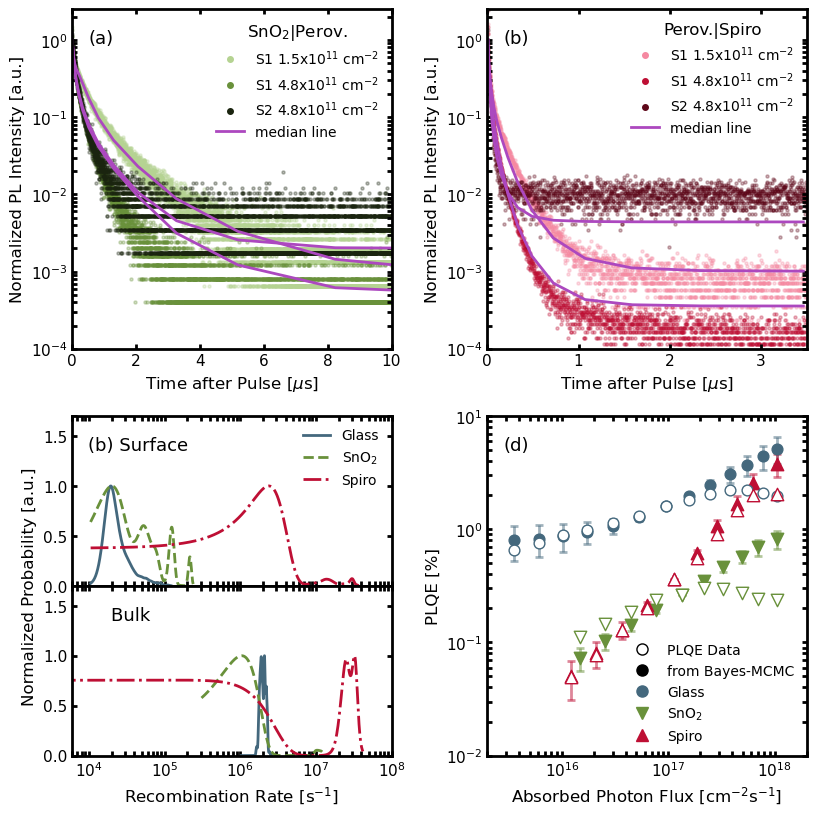

In [ ]:
fig_three_2 = plt.figure(figsize=(figure_width*centimeters, figure_width*centimeters))
#plt.subplots_adjust(wspace=0.2, hspace=0)
gs_three_2 = gridspec.GridSpec(4, 2)

gs0 = gridspec.GridSpec(2, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[1], hspace=0, wspace=0.3)

gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0], wspace=0.3)



ax_bottomright = fig_three_2.add_subplot(gs00[0:2, 1])
ax_bottomright.set_xlim(2e15,2e18)
ax_bottomright.set_ylim(1e-2,1e1)
ax_bottomright.set_xlabel('Absorbed Photon Flux [cm$^{-2}$s$^{-1}$]', fontsize=fontsize_base+1)
ax_bottomright.set_ylabel('PLQE [%]', fontsize=fontsize_base+1)
ax_bottomright.annotate('(d)' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)
ax_bottomright.set_xscale('log')
ax_bottomright.set_yscale('log')

ax_bottomleft = fig_three_2.add_subplot(gs00[0:2, 0])
#ax_bottomleft.set_xlim(150,2500)
#ax_bottomleft.set_ylim(0,2.3)
ax_bottomleft.set_xlabel('', fontsize=fontsize_base+1)
ax_bottomleft.set_xticklabels("")
ax_bottomleft.set_ylabel('Normalized Probability [a.u.]', fontsize=fontsize_base+1)
#ax_bottomleft.set_xlabel('Photon Wavelength [nm]', fontsize=fontsize_base+1)
ax_bottomleft.spines['top'].set_color('none')
ax_bottomleft.spines['bottom'].set_color('none')
ax_bottomleft.spines['left'].set_color('none')
ax_bottomleft.spines['right'].set_color('none')
ax_bottomleft.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


ax_bottomlefta = fig_three_2.add_subplot(gs00[0, 0])
ax_bottomlefta.annotate('(b) Surface' ,[0.05, 0.8] , xycoords='axes fraction', fontsize=fontsize_base+2)
ax_bottomlefta.set_xscale('log')
ax_bottomlefta.set_ylim(0,1.7)
ax_bottomlefta.set_xlim(6e3,1e8)
ax_bottomlefta.set_xlabel('', fontsize=fontsize_base+1)
ax_bottomlefta.set_xticklabels("")

ax_bottomleftb = fig_three_2.add_subplot(gs00[1, 0])
ax_bottomleftb.annotate('    Bulk' ,[0.05, 0.8] , xycoords='axes fraction', fontsize=fontsize_base+2)
ax_bottomleftb.set_xlabel('Recombination Rate [s$^{-1}$]', fontsize=fontsize_base+1)
ax_bottomleftb.set_xscale('log')
ax_bottomleftb.set_ylim(0,1.7)
ax_bottomleftb.set_xlim(6e3,1e8)



ax_topleft = fig_three_2.add_subplot(gs01[0, 0])
ax_topleft.set_xlim(0,10)
ax_topleft.set_ylim(1e-4,2.5)
ax_topleft.set_xlabel('Time after Pulse [$\mu$s]', fontsize=fontsize_base+1)
ax_topleft.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
ax_topleft.annotate('(a)' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)
ax_topleft.set_yscale('log')


ax_topright = fig_three_2.add_subplot(gs01[0, 1])
ax_topright.set_xlim(0,3.5)
ax_topright.set_ylim(1e-4,2.5)
ax_topright.set_xlabel('Time after Pulse [$\mu$s]', fontsize=fontsize_base+1)
ax_topright.set_ylabel('Normalized PL Intensity [a.u.]', fontsize=fontsize_base+1)
ax_topright.annotate('(b)' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)
ax_topright.set_yscale('log')


################# LOAD DATA #####################

#File_name = r"\\physics.ox.ac.uk\dfs\home\kober-czerny\00_Oxford_PhD\00_Snaith Group\Jongchul_Paper\TPC_Decay\TPC_Jong1_D1C1S1_670_processed.txt"
#Raw_File = pd.read_csv(File_name, sep="\t")
#values = Raw_File['name_of_parameter'].values


################# TOP RIGHT ##########################
File_name = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_07_20_Bayes_Seongrok_FAPI\Seo_SnO2_only_front_final_trace_data_norm.dat"
Raw_File = pd.read_csv(File_name, sep="\t")
Time = Raw_File["Time (ns)"].values
Data1 = Raw_File["1.5e+11[cm-2] S1"].values
Data2 = Raw_File["4.8e+11[cm-2] S1"].values
#Data3 = Raw_File["1.5e+11[cm-2] S2"].values
Data4 = Raw_File["4.8e+11[cm-2] S2"].values

ax_topleft.scatter(Time/1000,Data1, color='#b5d392', marker='.',s=20, alpha=0.3)
ax_topleft.scatter(Time/1000,Data2, color=color_scheme[1], marker='.',s=20, alpha=0.3)
#ax_topleft.scatter(Time/1000,Data3, color=color_scheme[2], marker='.',s=20, alpha=0.3)
ax_topleft.scatter(Time/1000,Data4, color='#1a240f', marker='.',s=20, alpha=0.3)

File_name = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_07_20_Bayes_Seongrok_FAPI\Seo_SnO2_only_front_final_trace_median_of_simulations.dat"
Raw_File = pd.read_csv(File_name, sep="\t")
Timefit = Raw_File["Time (ns)"].values
Fit1 = Raw_File["1.5e+11[cm-2] S1"].values
Fit2 = Raw_File["4.8e+11[cm-2] S1"].values
#Fit3 = Raw_File["1.5e+11[cm-2] S2"].values
Fit4 = Raw_File["4.8e+11[cm-2] S2"].values

ax_topleft.plot(Timefit/1000,Fit1, color=highlight_color, linewidth=2)
ax_topleft.plot(Timefit/1000,Fit2, color=highlight_color, linewidth=2)
#ax_topleft.plot(Timefit/1000,Fit3, color=highlight_color, linewidth=2)
ax_topleft.plot(Timefit/1000,Fit4,  color=highlight_color, linewidth=2)



################# Top_Right ##########################
File_name = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_07_20_Bayes_Seongrok_FAPI\Seo_Spiro_only_front_final_trace_data_norm.dat"
Raw_File = pd.read_csv(File_name, sep="\t")
Time = Raw_File["Time (ns)"].values
Data1 = Raw_File["4.8e+10[cm-2] S1"].values
Data2 = Raw_File["4.8e+11[cm-2] S1"].values
#Data3 = Raw_File["1.5e+11[cm-2] S2"].values
Data4 = Raw_File["4.8e+11[cm-2] S2"].values

ax_topright.scatter(Time/1000,Data1, color='#f589a1', marker='.',s=20, alpha=0.3)
ax_topright.scatter(Time/1000,Data2, color=color_scheme[3], marker='.',s=20, alpha=0.3)
#ax_topright.scatter(Time/1000,Data3, color=color_scheme[2], marker='.',s=20, alpha=0.3)
ax_topright.scatter(Time/1000,Data4, color='#5e081a', marker='.',s=20, alpha=0.3)

File_name = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\MKC06_Bayes\5_Data Collection\TRPL\2023_07_20_Bayes_Seongrok_FAPI\Seo_Spiro_only_front_final_trace_median_of_simulations.dat"
Raw_File = pd.read_csv(File_name, sep="\t")
Timefit = Raw_File["Time (ns)"].values
Fit1 = Raw_File["4.8e+10[cm-2] S1"].values
Fit2 = Raw_File["4.8e+11[cm-2] S1"].values
#Fit3 = Raw_File["1.5e+11[cm-2] S2"].values
Fit4 = Raw_File["4.8e+11[cm-2] S2"].values

ax_topright.plot(Timefit/1000,Fit1, linestyle=line_type_list[0], color=highlight_color, linewidth=2)
ax_topright.plot(Timefit/1000,Fit2, linestyle=line_type_list[0], color=highlight_color, linewidth=2)
#ax_topright.plot(Timefit/1000,Fit3, linestyle=line_type_list[0], color=highlight_color, linewidth=2)
ax_topright.plot(Timefit/1000,Fit4, linestyle=line_type_list[0], color=highlight_color, linewidth=2)

################### Bottom Left ##########################
def plot_kernel_1D(a):
    x_a = np.logspace(np.log10(np.min(a))-0.2,np.log10(np.max(a)+0.2),1000)
    kernel_1d = stats.gaussian_kde(a)(x_a)
    return x_a, kernel_1d


S_rate = S_sum_model_values/(Thickness*1e-7)
S_rateSnO2 = S_sum_model_valuesSnO2/(Thickness*1e-7)
S_rateSpiro = S_sum_model_valuesSpiro/(Thickness*1e-7)


ax_bottomlefta.plot(plot_kernel_1D(S_rate)[0],plot_kernel_1D(S_rate)[1]/(plot_kernel_1D(S_rate)[1].max()), linestyle=line_type_list[0], color=color_scheme[0], linewidth=2)
ax_bottomleftb.plot(plot_kernel_1D(kc_n_model_values)[0],plot_kernel_1D(kc_n_model_values)[1]/(plot_kernel_1D(kc_n_model_values)[1].max()), linestyle=line_type_list[0], color=color_scheme[0], linewidth=2)

ax_bottomlefta.plot(plot_kernel_1D(S_rateSnO2)[0],plot_kernel_1D(S_rateSnO2)[1]/(plot_kernel_1D(S_rateSnO2)[1].max()), linestyle=line_type_list[2], color=color_scheme[1], linewidth=2)
ax_bottomleftb.plot(plot_kernel_1D(kc_n_model_valuesSnO2)[0],plot_kernel_1D(kc_n_model_valuesSnO2)[1]/(plot_kernel_1D(kc_n_model_valuesSnO2)[1].max()), linestyle=line_type_list[2], color=color_scheme[1], linewidth=2)

ax_bottomlefta.plot(plot_kernel_1D(S_rateSpiro)[0],plot_kernel_1D(S_rateSpiro)[1]/(plot_kernel_1D(S_rateSpiro)[1].max()), linestyle=line_type_list[1], color=color_scheme[3], linewidth=2)
ax_bottomleftb.plot(plot_kernel_1D(kc_n_model_valuesSpiro)[0],plot_kernel_1D(kc_n_model_valuesSpiro)[1]/(plot_kernel_1D(kc_n_model_valuesSpiro)[1].max()), linestyle=line_type_list[1], color=color_scheme[3], linewidth=2)




################# Bottom right ##########################
ax_bottomright.errorbar(Generation_Rates, PLQE_mean*100, yerr=PLQE_std*100, markersize=1 ,fmt="o",  lw=2, capsize=3, capthick=2, color=color_scheme[0], zorder=-1000, alpha=0.5)
ax_bottomright.scatter(Generation_Rates, PLQE_mean*100, marker='o',s=60 ,color=color_scheme[0],zorder=0)
ax_bottomright.scatter(Generation_Rates, Data*100, marker='o', s=60, facecolor='w', color=color_scheme[0],zorder=100)

ax_bottomright.errorbar(Generation_Rates_SnO2, PLQE_meanSnO2[:,0]*100, yerr=PLQE_stdSnO2[:,0]*100, markersize=1 ,fmt="o",  lw=2, capsize=3, capthick=2, color=color_scheme[1], zorder=-1000, alpha=0.5)
ax_bottomright.scatter(Generation_Rates_SnO2, PLQE_meanSnO2[:,0]*100, marker='v', s=80,color=color_scheme[1],zorder=0)
ax_bottomright.scatter(Generation_Rates_SnO2, Data_SnO2*100, marker='v', s=80, facecolor = 'w', color=color_scheme[1],zorder=100)


ax_bottomright.errorbar(Generation_Rates_Spiro, PLQE_meanSpiro[:,0]*100, yerr=PLQE_stdSpiro[:,0]*100, markersize=1 ,fmt="o",  lw=2, capsize=3, capthick=2, color=color_scheme[3], zorder=-1000, alpha=0.5)
ax_bottomright.scatter(Generation_Rates_Spiro, PLQE_meanSpiro[:,0]*100, marker='^', s=80,color=color_scheme[3],zorder=0)
ax_bottomright.scatter(Generation_Rates_Spiro, Data_Spiro*100, marker='^', s=80, facecolor = 'w', color=color_scheme[3],zorder=100)


#####################################



################# PLOTTING DATA #####################



#####################################
############### Legend #############


legend_elements_bottomleft = []
legend_elements_bottomright = []
legend_elements_left = []
legend_elements_right = []

legend_elements_bottomright.append(Line2D([0], [0], marker="o", markersize=8 , markerfacecolor='w', color='black', lw=0 ,label="PLQE Data"))
legend_elements_bottomright.append(Line2D([0], [0], marker="o", markersize=8 ,color='black', lw=0 ,label="from Bayes-MCMC"))
legend_elements_bottomright.append(Line2D([0], [0], marker="o", markersize=8 ,color=color_scheme[0], lw=0 ,label="Glass"))
legend_elements_bottomright.append(Line2D([0], [0], marker="v", markersize=8 ,color=color_scheme[1], lw=0 ,label="SnO$_2$"))
legend_elements_bottomright.append(Line2D([0], [0], marker="^", markersize=8 ,color=color_scheme[3], lw=0 ,label="Spiro"))

legend_elements_left.append(Line2D([0], [0], marker='.',markersize=8 ,color='#b5d392', lw=0, label='S1 1.5x10$^{11}$ cm$^{-2}$'))
legend_elements_left.append(Line2D([0], [0], marker='.',markersize=8 ,color=color_scheme[1], lw=0, label='S1 4.8x10$^{11}$ cm$^{-2}$'))
legend_elements_left.append(Line2D([0], [0], marker='.',markersize=8 ,color='#1a240f', lw=0, label='S2 4.8x10$^{11}$ cm$^{-2}$'))
legend_elements_left.append(Line2D([0], [0], marker=None ,color=highlight_color, lw=2, label='median line'))


legend_elements_right.append(Line2D([0], [0], marker='.',markersize=8 ,color='#f589a1', lw=0, label='S1 1.5x10$^{11}$ cm$^{-2}$'))
legend_elements_right.append(Line2D([0], [0], marker='.',markersize=8 ,color=color_scheme[3], lw=0, label='S1 4.8x10$^{11}$ cm$^{-2}$'))
legend_elements_right.append(Line2D([0], [0], marker='.',markersize=8 ,color='#5e081a', lw=0, label='S2 4.8x10$^{11}$ cm$^{-2}$'))
legend_elements_right.append(Line2D([0], [0], marker=None ,color=highlight_color, lw=2, label='median line'))


legend_elements_bottomleft.append(Line2D([0], [0], marker=None,color=color_scheme[0], linestyle=line_type_list[0], lw=2, label="Glass"))
legend_elements_bottomleft.append(Line2D([0], [0], marker=None,color=color_scheme[1], linestyle=line_type_list[2], lw=2, label="SnO$_2$"))
legend_elements_bottomleft.append(Line2D([0], [0], marker=None,color=color_scheme[3], linestyle=line_type_list[1], lw=2, label="Spiro"))


ax_topleft.legend(title='SnO$_2$|Perov.', handles=legend_elements_left, frameon=False, title_fontsize=fontsize_base+1)
ax_topright.legend(title='Perov.|Spiro', handles=legend_elements_right, frameon=False, title_fontsize=fontsize_base+1)


ax_bottomright.legend(handles=legend_elements_bottomright, frameon=False, title_fontsize=fontsize_base+1, loc="lower right")
ax_bottomlefta.legend(handles=legend_elements_bottomleft, frameon=False, title_fontsize=fontsize_base+1, loc="upper right")





############################################
################## Finishing the Figure ###################
for plot_name in [ax_topleft, ax_topright, ax_bottomleft,ax_bottomlefta, ax_bottomleftb, ax_bottomright]:
    for axis in ['top', 'bottom', 'left', 'right']:
        plot_name.spines[axis].set_linewidth(2)
    plot_name.tick_params(bottom=True,top=True,left=True,right=True,
                   direction='in',width=2, length=3.5, which='both', labelsize=fontsize_base, zorder=2000)

    
plt.tight_layout()
savefolder = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\Thesis\Figures\6_"
figurename = 'fig_halfstacks_TRPL_PLQE'
plt.savefig(f'{savefolder}/{figurename}.pdf', format='pdf', dpi=300)
plt.savefig(f'{savefolder}/{figurename}.png', format='png', dpi=300, transparent=True)

plt.show()

In [ ]:
print(np.mean(S_2Spiro))
print(np.std(S_2Spiro))

328.03018317639805
460.30005192543575


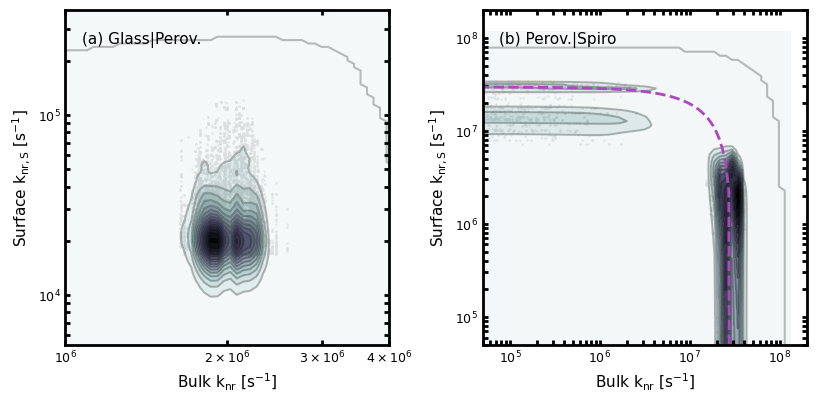

In [ ]:
centimeters = 1/2.54
fontsize_base = 11

fig_two = plt.figure(figsize=(figure_width*centimeters, figure_width/2*centimeters))
plt.subplots_adjust(wspace=0.2, hspace=0)
gs_two = gridspec.GridSpec(1, 2)

ax_left = fig_two.add_subplot(gs_two[0, 0])
ax_left.set_xlim(1e6,4e6)
#ax_left.set_ylim(1e4,1e5)


ax_right = fig_two.add_subplot(gs_two[0, 1])
ax_right.set_xlim(5e4,2e8)
ax_right.set_ylim(5e4,2e8)


def corner_plot_single(a, b, a_label, b_label, ax_plot, cornerlabel):
    ## Method 3: Kernel Density Estimation
    def kernel_2D(a, b):
        
        Matrix_ab = np.vstack([a,b])
    
        x_a1, x_b1 = np.logspace(np.log10(np.min(a))-0.5,np.log10(np.max(a))+0.5,100) , np.logspace(np.log10(np.min(b))-0.5,np.log10(np.max(b))+0.5,100) 
        x_a, x_b = np.meshgrid(x_a1, x_b1)
        
        kernel_ab = stats.gaussian_kde(Matrix_ab)(np.vstack([x_a.ravel(), x_b.ravel()]))
        kernel_2d = np.reshape(kernel_ab.T, x_a.shape)
    
        return x_a, x_b, kernel_2d
    
    x_a, x_b, test_kernel = kernel_2D(a, b)
    
    
    
    ax_plot.scatter(a,b,s=1,color='black',alpha=0.5)
    ax_plot.contourf(x_a, x_b, test_kernel, levels=15, cmap='bone_r',alpha=0.9)
    ax_plot.contour(x_a, x_b, test_kernel, levels=15, colors='black',alpha=0.25)

    ax_plot.set_xlabel(a_label, fontsize=fontsize_base)
    ax_plot.set_ylabel(b_label, fontsize=fontsize_base)
    ax_plot.text(0.05, 0.9, cornerlabel, transform=ax_plot.transAxes, fontsize=fontsize_base)
    ax_plot.set_yscale('log')
    ax_plot.set_xscale('log')
    
    
    for axis in ['top', 'bottom', 'left', 'right']:
        ax_plot.spines[axis].set_linewidth(2)
    ax_plot.tick_params(bottom=True,top=True,left=True,right=True,
                   direction='in',width=2, length=3.5, which='both', labelsize=fontsize_base-2, zorder=2000)
    





A_test = kc_n_model_valuesSpiro
B_test = S_sum_model_valuesSpiro/(Thickness*1e-7)

rate_sum_median = np.median(B_test+A_test)


corner_plot_single(kc_n_model_values, S_sum_model_values/(Thickness*1e-7), "Bulk k$_{\mathrm{nr}}$ [s$^{-1}$]", "Surface k$_{\mathrm{nr,S}}$ [s$^{-1}$]", ax_left, '(a) Glass|Perov.')
corner_plot_single(A_test, B_test, "Bulk k$_{\mathrm{nr}}$ [s$^{-1}$]", "Surface k$_{\mathrm{nr,S}}$ [s$^{-1}$]", ax_right, '(b) Perov.|Spiro')

k_nr_bulk_calc = np.logspace(4,np.log10(rate_sum_median), 100)
k_nr_surf_calc = rate_sum_median - k_nr_bulk_calc


ax_right.plot(k_nr_bulk_calc, k_nr_surf_calc, c=highlight_color, linestyle=line_type_list[2], lw=2)

x_test = np.logspace(-2,1,100)

#ax_corner_1.plot(x_test, np.exp(2*x_test)+0.6)
plt.tight_layout()
savefolder = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\Thesis\Figures\6_"
figurename = 'fig_halfstacks_cornerplots'
plt.savefig(f'{savefolder}/{figurename}.pdf', format='pdf', dpi=300)
plt.savefig(f'{savefolder}/{figurename}.png', format='png', dpi=300, transparent=True)




In [ ]:


sum_rate = (A_test+B_test)*Thickness*1e-7

print(np.mean(sum_rate))
print(np.std(sum_rate))


1503.4228209560388
346.5371470753549


In [ ]:
krad_comb  = np.array([kc_n_model_values, kc_n_model_valuesSnO2, kc_n_model_valuesSpiro])

print(np.mean(krad_comb))
print(np.std(krad_comb))

8996783.171281155
12253044.70001289


# List of Plots

- FAPI Mobility vs. TPC
- FAPI cross-sectional SEM

- Evap Parameters
- Evap Mobility vs. TPC
- 

## Plots for Chapter
- cross-sectional SEM side-by-side with TPC mobility vs. Bayes Mobility


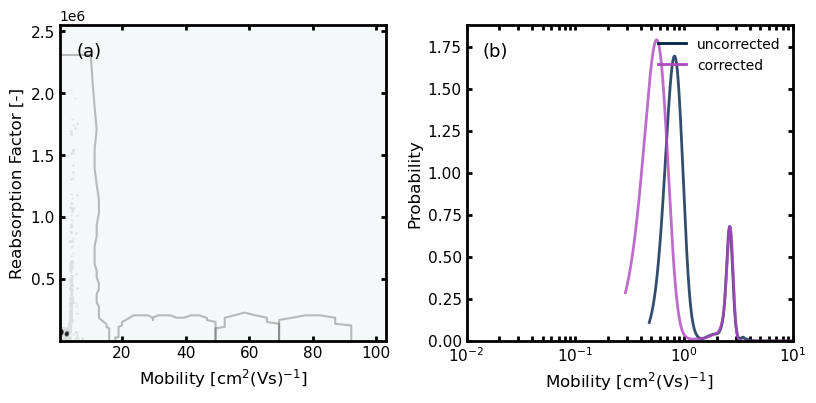

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.image as image

def plot_kernel_1D(a):
    x_a = np.logspace(np.log10(np.min(a)),np.log10(np.max(a))+0.1,1000)
    kernel_1d = stats.gaussian_kde(a)(x_a)
    return x_a, kernel_1d



### Oxford color scheme
base_color = "#002147"
color_scheme = ["#44687d", "#69913b", '#cf7a30', '#be0f34']
highlight_color = "#ac48bf"

line_type_list = ['-', '-.', '--', ':']

centimeters = 1/2.54
fontsize_base = 11
figure_width = 21


fig_two = plt.figure(figsize=(figure_width*centimeters, figure_width/2*centimeters))
plt.subplots_adjust(wspace=0.2, hspace=0)
gs_two = gridspec.GridSpec(1, 2)

ax_left = fig_two.add_subplot(gs_two[0, 0])
#ax_left.set_xlim(150,2500)
#ax_left.set_ylim(0,2.3)
ax_left.annotate('(a)' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)

ax_right = fig_two.add_subplot(gs_two[0, 1])
#ax_right.set_xlim(150,2500)
#ax_right.set_ylim(0,2.3)
ax_right.set_xlabel('Mobility [cm$^{2}$(Vs)$^{-1}$]', fontsize=fontsize_base+1)
ax_right.set_ylabel('Probability', fontsize=fontsize_base+1)
ax_right.annotate('(b)' ,[0.05, 0.9] , xycoords='axes fraction', fontsize=fontsize_base+2)


def corner_plot_single(a, b, a_label, b_label, ax_plot, cornerlabel):
    ## Method 3: Kernel Density Estimation
    def kernel_2D(a, b):
        
        Matrix_ab = np.vstack([a,b])
    
        x_a1, x_b1 = np.logspace(np.log10(np.min(a))-0.1,np.log10(np.max(a))+0.1,100) , np.logspace(np.log10(np.min(b))-0.1,np.log10(np.max(b))+0.1,100) 
        x_a, x_b = np.meshgrid(x_a1, x_b1)
        
        kernel_ab = stats.gaussian_kde(Matrix_ab)(np.vstack([x_a.ravel(), x_b.ravel()]))
        kernel_2d = np.reshape(kernel_ab.T, x_a.shape)
    
        return x_a, x_b, kernel_2d
    
    x_a, x_b, test_kernel = kernel_2D(a, b)
    
    
    
    ax_plot.scatter(a,b,s=1,color='black',alpha=0.5)
    ax_plot.contourf(x_a, x_b, test_kernel, levels=15, cmap='bone_r',alpha=0.9)
    ax_plot.contour(x_a, x_b, test_kernel, levels=15, colors='black',alpha=0.25)

    ax_plot.set_xlabel(a_label, fontsize=fontsize_base+1)
    ax_plot.set_ylabel(b_label, fontsize=fontsize_base+1)
    ax_plot.text(0.05, 0.9, cornerlabel, transform=ax_plot.transAxes, fontsize=fontsize_base+1)
    ax_plot.set_yscale('log')
    ax_plot.set_xscale('log')
    
    



    
    
    
Mob_collect = np.array([Mobilities, Mobilities]).flatten()

Reabs_combined = np.exp(-Reabs_1*Thickness*1e-7) +np.exp(-Thickness*1e-7*Reabs_2)
#Reabs_combinedSnO2 = 1*np.exp(-Reabs_1_SnO2*Thickness*1e-7/2) * Reabs_edge_SnO2*np.exp(-Thickness*1e-7*Reabs_2_SnO2/2)#Reabs_edge*np.exp(-Thickness*1e-7*Reabs_2_SnO2)#Reabs_edge_SnO2*np.exp(-(Reabs_1_SnO2 + Reabs_2_SnO2)/2*Thickness*1e-7)
#Reabs_combinedSpiro = np.exp(-(Reabs_1_Spiro + Reabs_2_Spiro)/2*Thickness*1e-7)

Reabs_collect = np.array([Reabs_combined,Reabs_combined]).flatten()

Reabs_sum = np.array([Reabs_1 + Reabs_2, Reabs_1 + Reabs_2]).flatten()

A_test = Mobilities
B_test = Reabs_1

corner_plot_single(A_test, B_test, "Mobility [cm$^{2}$(Vs)$^{-1}$]", "Reabsorption Factor [-]", ax_left, ' ')


ax_right.plot(plot_kernel_1D(Mob_collect)[0], plot_kernel_1D(Mob_collect)[1], c=base_color, linewidth=2, alpha=0.8)

Mob_corrected = Mob_collect*Reabs_collect

ax_right.plot(plot_kernel_1D(Mob_corrected)[0], plot_kernel_1D(Mob_corrected)[1], c=highlight_color, linewidth=2, alpha=0.8)

legend_elements_left = []
legend_elements_right = []


legend_elements_right.append(Line2D([0], [0], marker=None ,color=base_color, lw=2, label='uncorrected'))
legend_elements_right.append(Line2D([0], [0], marker=None ,color=highlight_color, lw=2, label='corrected'))

    
ax_right.legend(handles=legend_elements_right, frameon=False, title_fontsize=fontsize_base+1, loc='upper right')



# Model:
Mobility_base = 0.25

Reabs_calc = np.logspace(-2,0,100)

Mobility_calc = Mobility_base/Reabs_calc

#ax_left.plot(Mobility_calc,Reabs_calc, lw=2, linestyle=line_type_list[2], color=highlight_color)



ax_right.set_xscale('log')
ax_right.set_ylim(0,None)
ax_right.set_xlim(1e-2,1e1)


for plot_name in [ax_left, ax_right]:
    for axis in ['top', 'bottom', 'left', 'right']:
        plot_name.spines[axis].set_linewidth(2)
    plot_name.tick_params(bottom=True,top=True,left=True,right=True,
                   direction='in',width=2, length=3.5, which='both', labelsize=fontsize_base, zorder=2000)

    
savefolder = r"C:\Users\kober-czerny\OneDrive - Nexus365\00_Oxford_PhD\00_Snaith Group\Projects_Collection\Thesis\Figures\6_"
plt.tight_layout()
figurename = 'fig_reabs_mobility'
#plt.savefig(f'{savefolder}/{figurename}.pdf', format='pdf', dpi=300)
#plt.savefig(f'{savefolder}/{figurename}.png', format='png', dpi=300, transparent=True)


plt.show()

In [ ]:
print(np.median(Reabs_edge_SnO2))

0.8558889557260382


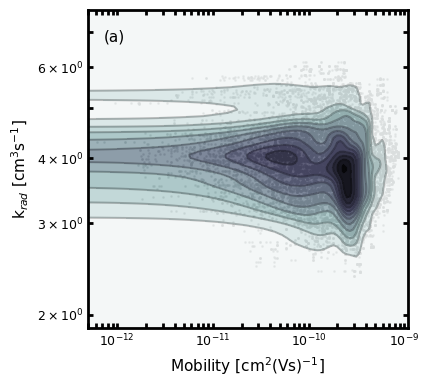

In [ ]:
fig_corner_1 = plt.figure(figsize=(10.5*centimeters, 10.5*centimeters))
#plt.subplots_adjust(wspace=0.2, hspace=0.35)
gs_corner_1 = gridspec.GridSpec(1, 1)
ax_corner_1 = fig_corner_1.add_subplot(gs_corner_1[0,0])

A_test = k_rad_model_values
B_test = Mobilities

corner_plot_single(A_test, B_test, "Mobility [cm$^{2}$(Vs)$^{-1}$]", "k$_{rad}$ [cm$^{3}$s$^{-1}$]", ax_corner_1, '(a)')


plt.show()

C:\Users\kober-czerny\AppData\Local\Temp\ipykernel_11024\2594344463.py:6: RuntimeWarning: divide by zero encountered in power
  D_ext = D_int*t**alpha


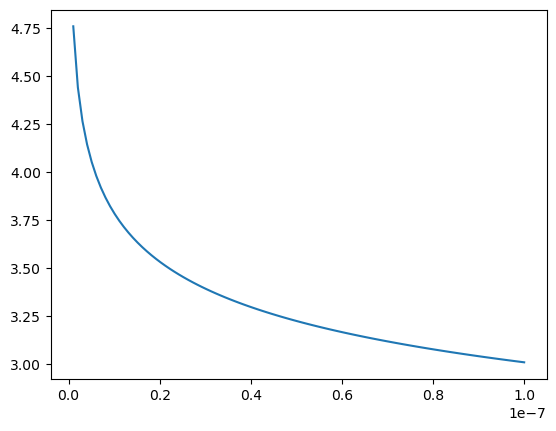

In [ ]:
D_int = 0.6

alpha = -0.1
t = np.linspace(0,100,100)*1e-9

D_ext = D_int*t**alpha


plt.plot(t,D_ext)


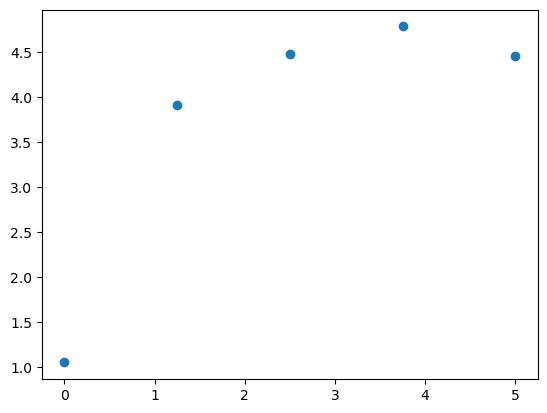

In [ ]:
x = np.linspace(0,5,5)

D1 = 2.75

D2 = 0.65

mix = 0.3


D_mix = x**mix*D1 + (5-x)**mix*D2

plt.scatter(x, D_mix)